# 데이터 변환

* Last updated 202311_202011_201911_201810_201704_201611

숫자, 텍스트로 구성된 RDD 또는 DataFrame을 기계학습의 입력으로 사용될 수 있도록 변환한다.

* S.3 데이터 변환
* S.4 RDD 변환: vectors (Dense, Sparse Vectors), Matrix, svm 입력 형식, TF-IDFm StandardScaler
* S.5 DataFrame 변환: Labeled Point, 텍스트 변환, transformer/ estimator, Tokenizer, RegTokenizer, Stopwords
    * CountVectorizerm, TF-IDF, Word2Vec, NGram, tringIndexer, 연속데이터의 변환, VectorAssembler, Pipeline
    * 연설문을 기계학습하기 위해 변환
    * 트윗 정서 분석

## S.2 Jupyter Notebook에서 SparkSession 생성하기


In [2]:
import os, sys
os.environ["PYSPARK_PYTHON"]=sys.executable #"/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable #"/usr/bin/python3"

In [3]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [4]:
spark.version

'3.5.2'

## S.3 데이터 변환

원천데이터는 그대로는 사용하기 어렵고, 타겟으로 하는 모델의 입력으로 어떻게든 변환되어야 한다.

이전의 데이터웨어하우스는 주로 구조화된 데이터를 사용해서 스키마도 정해있고, 사전 정의된 쿼리 및 분석을 수행한다.

예를 들어, 금융기관의 경우, 금감원에 정기적으로 제출하는 보고서나 경영층이 필요한 고객군별 매출, 분기별 매출, 이익 등 필요한 쿼리를 사전에 작성하고 일괄 실행해 놓는다 (OLAP: On Line Analytical Processing 온라인 분석처리라고 한다).

이를 위해서 **ETL** (Extract, Transform, Load)이라는 작업을 하는데, 소스에서 필요한 데이터를 추출, 변환하고, 다른 타켓으로 로딩하는 것으로 말한다.

빅데이터의 분석은 텍스트와 같은 비구조적 데이터를 대상으로 하고 있으며, 앞서 배운 Map Reduce 알고리즘을 적용하고 있다.

이를 위해 마찬가지로 ETL이 필요하다. 웹, 파일, 데이터베이스의 원천 데이터에서 읽어서, 분석 가능한 형식으로 **변환**하고 (맵리듀스 Map Reduce) 예측, 분류, 군집화, 추천 등 기계학습 모델에 로딩한다. 예를 들어, 지도학습 Supervised Learning을 하려면, DataFrame은 label, features 컬럼을, **RDD는 label과 features를 가지고 있는 Labeled Point로 구성**해야 한다.

이러한 기계학습은 무작정 데이터를 우겨 넣고, 의미있는 결과가 나오기를 기다려서는 작동되지 않는다.
입력될 데이터를 정련하고, 가공하고, 일정한 형식을 가지도록 구성하는 것이 필요하다. 

In [5]:
import iplantuml

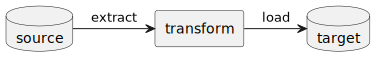

In [6]:
%%plantuml
@startuml
database source
rectangle transform
source -right-> transform: extract
database target
transform -right-> target: load
@enduml

- 주의: iplantuml을 사용하려면 plantuml.jar 파일을 Jupyter Notebook이 접근할 수 있는 위치에 저장해야 한다. 경로를 지정하려면:

```
os.environ["PLANTUML_JAR"] = "/path/to/plantuml.jar"
```

또는 %%plantuml --jar /path/to/plantuml.jar 이렇게 경로를 지정할 수 있다.

Spark 초기에는 RDD를 사용하여 데이터를 변환하고, mllib 라이브러리를 사용하여 기계학습을 하였다.
그 후 DataFrame이 소개되고 나서, ml 라이브러리가 사용되고 있다.
Spark 2.0부터 mllib는 유지보수로 지원된다고 한다. 오류가 있으면 수정되지만, 새로운 기능이 추가되지는 않고 있다.
반면에 ml 라이브러리는 새로운 기능이 추가되고 있다.

따라서 Spark에서는 **```RDD mllib```** , **```DataFrame ml```** 패키지 별로 데이터 타입이나 모델이 제공되므로, 식별하여 사용한다.
```ml``` 패키지를 사용할 경우에는 자신의 ```pyspark.ml.linalg.Vector``` 등을 사용해야 한다. ```mllib```도 마찬가지이다.

패키지 | 설명 | 데이터 타입 예
-------|-------|-----
```mllib``` | RDD API를 제공 | ```pyspark.mllib.linalg.Vector``` 또는 ```pyspark.mllib.linalg.Matrix```
```ml``` | DataFrame API를 제공 | ```pyspark.ml.linalg.Vector``` 또는 ```pyspark.ml.linalg.Matrix```


## S.4 RDD 변환

기계학습을 하기 위해서는 데이터를 일정 형식으로 만들어 주어야 한다.
**```Vector```**, **```Labeled Point```**, **```Matrix```**를 배워보자.

구분 | 설명
----------|----------
```Vector``` | ```numpy vector```와 같은 기능을 한다. **dense**와 **sparse** vector로 구분한다.
```Labeled Point``` | 분류를 의미하는 클래스 또는 **label**과 속성 **features** 이 묶인 구조로서, 지도학습 supervised learning을 할 경우 사용된다.
```Matrix``` | ```numpy matrix```와 같은 특징을 가진다.

### S.4.1 vectors

행렬 **Vector**는 **dense**와 **sparse**로 구분할 수 있다.

* 밀집벡터dense vector는 빈 값이 별로 없이 **모든** 행열이 값을 가지고 있다.
* 희소벡터sparse vector는 빈 값이 많아서, 값이 있는 경우 그 값이 있는 **인덱스**로 표현해 배열을 축약하게 된다.

#### Dense Vectors 밀집벡터

벡터는 일련의 수로 구성이 되고, 행벡터 또는 열벡터가 될 수 있다. 채워지는 값이 대부분 0이면 희소벡터 Sparse Vectors로 만들어 질 수 있다.

numpy 라이브러리를 가져오자.

In [7]:
import numpy as np

numpy array를 사용하면 만들어지는 것이 dense vector이다.

In [8]:
dv = np.array([1.0, 2.1, 3])

Spark에서는 Vectors 명령어로 벡터를 만들 수 있다.
단 **RDD는 mllib** 모듈을 사용해서 vectors를 만들고, 반면에 **```DataFrame```**은 **ml**를 사용한다는 점에 유의하자.

In [9]:
from pyspark.mllib.linalg import Vectors

dv1mllib=Vectors.dense([1.0, 2.1, 3])

만든 벡터를 출력해보자. 그 타입도 확인하면 DenseVector이다.

In [11]:
print ("Dense vector: {}\nType: {}".format(dv1mllib, type(dv1mllib)))

Dense vector: [1.0,2.1,3.0]
Type: <class 'pyspark.mllib.linalg.DenseVector'>


이번에는 ```pyspark.ml``` 모듈을 이용하여 Vectors를 생성해보자. 

In [12]:
from pyspark.ml.linalg import Vectors

dv1ml=Vectors.dense([1.0, 2.1, 3])

In [13]:
print ("ml의 dense vector: {}".format(dv1ml))

ml의 dense vector: [1.0,2.1,3.0]


dense vectors는 numpy array와 같은 특징을 가진다.
인덱스로 값을 읽을 수 있다. 또한 반복문에서 사용할 수 있다.

In [14]:
for e in dv1mllib:
    print (e, end = " ")

1.0 2.1 3.0 

보통 벡터와 같이 **product**, **dot**, **norm**과 같은 벡터 연산을 할 수도 있다.
결과 값은 numpy와 동일하다.

각 요소를 곱하고 더해서 1.0 x 1.0 + 2.1 x 2.1 + 3.0 x 3.0 = 14.41이다

In [15]:
dv1mllib.dot(dv1mllib)

np.float64(14.41)

In [16]:
np.dot(dv,dv)

np.float64(14.41)

더하기, 빼기, 곱하기, 나누기 연산도 가능하다. 곱하기 연산을 해보자. dot와 달리 항목별로 실행한다.

In [17]:
dv1mllib*dv1mllib

DenseVector([1.0, 4.41, 9.0])

#### Sparse Vectors 희소행렬

행렬에는 0 값이 많이 존재하기 때문에, 0값이 아닌 **NZ Nonzero**만 저장하면 훨씬 효율적이다.
**sparse**는 실제 **값이 없는 요소, '0'을 제거**하여 만든 vector이다.
Spark에서 type field (1 바이트 길이)를 통해 식별한다 (0: sparse, 1: dense)

예를 들어, 다음은 1차원 dense vector이다.
```python
[160, 69, 0, 0, 24]
```

sparse vectors는 값 중에 0이 포함된 경우 이를 생략하고, 값이 있는 요소 Nonzero만 남기게 된다.
5는 컬럼 갯수, 0, 1, 4는 값이 있는 컬럼, [160.0, 69.0, 24.0]는 실제 값을 의미한다.

In [18]:
sv1 = Vectors.sparse(5,[0,1,4],[160.0,69.0,24.0])

어느 모듈, mllib 또는 ml인지 확인해보자.

In [19]:
type(sv1)

pyspark.ml.linalg.SparseVector

```toArray()``` 함수를 사용하면 sparse에서 dense로 벡터를 변환할 수 있다.

In [20]:
sv1.toArray()

array([160.,  69.,   0.,   0.,  24.])

### S.4.2 Matrix

로컬 Matrix 역시 밀집 dense, 희소 sparse형식을 지원한다.

#### Dense Matrix

3행, 2열의 2차원 행렬
```
1 4
2 5
3 6
```
는 ```[1, 2, 3, 4, 5, 6]```로 표현한다.

In [21]:
from pyspark.mllib.linalg import Matrices

Matrices.dense(3, 2, [1,2,3,4,5,6])

DenseMatrix(3, 2, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], False)

밀집매트릭스를 배열형식으로 출력해보자.

In [22]:
Matrices.dense(3, 2, [1,2,3,4,5,6]).toArray()

array([[1., 4.],
       [2., 5.],
       [3., 6.]])

#### 열기반 희소행렬

밀집행렬(2차원)을 희소행렬로 변환해보자.

```python
[1 0 2]
[0 0 3]
[4 5 6]
```

scipy의 sparse vectors로 표현해보자.

scipy.sparse.csc_matrix (Compressed Sparse Column matrix)는 SciPy 라이브러리에서 제공하는 희소 행렬(Sparse Matrix)의 한 유형이다.

csc는 컬럼별로 읽으면 1,4,5,2,3,6 순서로 출력한다.

In [23]:
from scipy.sparse import csc_matrix

sparse_csc = csc_matrix([[1, 0, 2],
                         [0, 0, 3],
                         [4, 5, 6]])
print(sparse_csc)

  (np.int32(0), np.int32(0))	1
  (np.int32(2), np.int32(0))	4
  (np.int32(2), np.int32(1))	5
  (np.int32(0), np.int32(2))	2
  (np.int32(1), np.int32(2))	3
  (np.int32(2), np.int32(2))	6


csr_matrix는 row별로 읽고 1,2,3,4,5,6 순으로 출력된다.

In [24]:
from scipy.sparse import csr_matrix

sparse_csr = csr_matrix([[1, 0, 2],
                         [0, 0, 3],
                         [4, 5, 6]])
print(sparse_csr)

  (np.int32(0), np.int32(0))	1
  (np.int32(0), np.int32(2))	2
  (np.int32(1), np.int32(2))	3
  (np.int32(2), np.int32(0))	4
  (np.int32(2), np.int32(1))	5
  (np.int32(2), np.int32(2))	6


출력설명: 위와 같은 2차원 dense vectors를 sparse vectors의 배열 방식으로 표현한다.
우선 다음과 같이
행, 열, 값 vector를 만든다.

```python
행 | 0 | 0 | 1 | 2 | 2 | 2
열 | 0 | 2 | 2 | 0 | 1 | 2
값 | 1 | 2 | 3 | 4 | 5 | 6
```

행을 보면 0번째에 '1','2' 1번째에 '3', 2번째에 '4','5','6'이므로 **0,0,1,2,2,2**
열을 보면 0번째에 '1', 2번째 '2','3', 0번째 '4', 1번째 '5', 2번째 '6'이므로 **0,2,2,0,1,2**

**행, 열, 데이터를 한 쌍**으로 읽으면 된다.
즉 행 0, 열 0의 위치에 1, 행 0, 열 2의 위치에 2. 이런 식으로 6개의 데이터가 있다.

2차원 dense vectors를 만들어 보자.
행의 갯수, 열의 갯수, 실제 값을 넣어주면 생성된다.
* 6은 행 갯수
* 4는 열 갯수
* 다음 수는 행렬을 해체하여 연속적인 수로 나열

In [25]:
from pyspark.mllib.linalg import Matrices

dm = Matrices.dense(6,4,[1, 2, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 5, 6, 7, 0, 0, 0, 0, 0, 0, 8])

위를 2차원 배열로 변환해자.

In [26]:
dm.toArray()

array([[1., 0., 0., 0.],
       [2., 3., 0., 0.],
       [0., 0., 5., 0.],
       [0., 4., 6., 0.],
       [0., 0., 7., 0.],
       [0., 0., 0., 8.]])

In [27]:
dm.toSparse()

SparseMatrix(6, 4, [0, 2, 4, 7, 8], [0, 1, 1, 3, 2, 3, 4, 5], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0], False)

출력 설명: 밀집행렬(아래)를 희소행렬로 변환한다.

```python
[ 1.,  0.,  0.,  0.]
[ 2.,  3.,  0.,  0.]
[ 0.,  0.,  5.,  0.]
[ 0.,  4.,  6.,  0.]
[ 0.,  0.,  7.,  0.]
[ 0.,  0.,  0.,  8.]
```

위 SparseMatrix(인자 6개)를 출력한다.

* 6은 행 갯수
* 4는 열 갯수
* 다음은 열포인터 IA [0, 2, 4, 7, 8]
    * **열**로 세어서 --->  **요소의 개수** 2, 2, 3, 1을 가지고 구성을 한다. 즉 열로 요소가 2, 2, 3, 1개 이다.
    * **0**:IA[0]=0개로 시작, **2**:IA[1]=IA[0]+2개, **4**:IA[2]=IA[1]+2개 **7**:IA[3]=IA[2]+3개, **8**:IA[4]=IA[3]+1개
* 다음은 행인덱스 JA [0, 1, 1, 3, 2, 3, 4, 5]
    * **행**으로 세어서 (맨 뒤 실제 값 리스트의 순서를 지켜서) ---> 0 1 1 3 2 3 4 5
    * 요소값 1은 **0**행에 있고, 나머지 요소값들 2:**1**행, 3:**1**행, 4:**3**행, 5:**2**행, 6:**3**행, 7:**4**행, 8:**5**행에 있다.
* 다음은 소수로 실제 값 리스트 [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
* 마지막: 행의 개수를 포함하는 여부 (False)

In [28]:
sm = Matrices.sparse(3, 2, [0, 1, 3], [0, 2, 1], [9, 6, 8])

In [29]:
d=sm.toDense()

In [30]:
print (d)

DenseMatrix([[9., 0.],
             [0., 8.],
             [0., 6.]])


* 아래는 행3, 열2개 행열로 [9., 0.], [0., 8.], [0., 6.] 값이다.
* 0,1,3: **0**:IA[0]=0으로 시작, **1**:IA[1]=IA[0]+1 (1열 개수: 9뿐이 없으므르 1), **3**:IA[2]=IA[1]+2 (2열 개수: 6,8이 있으므로 2)
* 0,2,1: 9:**0**행, 6:**2**행, 8:**1**행

### S.4.2 분산 Matrix

배열은 n차원을 가질 수 있고, 2차원인 경우에는 매트릭스라고 지칭한다.
매트릭스 역시 로컬과 분산으로 구분할 수 있다.
앞서 로컬 매트릭스는 라이브러리 명에서 눈치를 챌 수 있는데, ```pyspark.mllib.linalg.Matrix, Matrices```를 사용한다. 반면에 분산 매트릭스는 당연히 여러 노드에 분산해서 사용할 수 있고, ```pyspark.mllib.linalg.distributed```에 존재하는 Row Matrix, Indexed Row Matrix, Coordinate Matrix, Block Matrix를 사용하면 된다.

#### Row Matrix

RowMatrix는 ```pyspark.mllib.linalg.distributed```에서 제공되는 분산벡터로서, RDD vectors로부터 생성된다.
우선 리스트에서 RDD를 생성하고 이를 RowMatrix에 넘겨주자.

In [31]:
p = [[1.0,2.0,3.0],[1.1,2.1,3.1],[1.2,2.2,3.3]]

In [32]:
my=spark.sparkContext.parallelize(p)

In [33]:
my.collect()

[[1.0, 2.0, 3.0], [1.1, 2.1, 3.1], [1.2, 2.2, 3.3]]

RDD Vectors를 넘겨주어야 한다.

In [34]:
from pyspark.mllib.linalg.distributed import RowMatrix

rm=RowMatrix(my)

In [35]:
print (type(rm))

<class 'pyspark.mllib.linalg.distributed.RowMatrix'>


In [36]:
rm.rows.collect()

[DenseVector([1.0, 2.0, 3.0]),
 DenseVector([1.1, 2.1, 3.1]),
 DenseVector([1.2, 2.2, 3.3])]

In [37]:
rm.numRows()

3

In [38]:
rm.numCols()

3

#### Indexed Row Matrix

앞서 Row Matrix과 유사하지만, 파티션으로 나누어, 그러나 순서를 지켜서 저장이 된다.
따라서 시계열 데이터와 같이 순서가 있는 데이터를 저장하기에 적합하다.

순서인덱스와 벡터로 구성한다.

In [39]:
from pyspark.mllib.linalg.distributed import IndexedRow

irRdd = spark.sparkContext.parallelize([
    IndexedRow(1, [3, 1, 2]),
    IndexedRow(2, [1, 3, 2]),
    IndexedRow(3, [5, 4, 3]),
    IndexedRow(4, [6, 7, 4]),
    IndexedRow(5, [8, 9, 2]),
])

In [40]:
from pyspark.mllib.linalg.distributed import IndexedRowMatrix

irm = IndexedRowMatrix(irRdd)

In [41]:
print(irm.numRows())
print(irm.numCols())

6
3


## 문제 s-1: matrix에서 데이터프레임 생성

매트릭스에서 데이터프레임을 생성해보자.

In [140]:
from pyspark.mllib.linalg import Matrices

my = Matrices.dense(3, 2, [1,2,3,4,5,6])

밀집 매트릭스에서 바로 만들게 되면 오류가 발생한다.
또는 아래와 같이 toArray()한 후, 인자로 사용해도 역시 오류가 발생한다.
그 이유는 ```<class 'numpy.ndarray'>```에서 직접 만들 수 없기 때문이다.
따라서 tolist()로 변환한 후 데이터프레임을 생성하자.

In [141]:
my = Matrices.dense(3, 2, [1,2,3,4,5,6]).toArray().tolist()

In [142]:
df = spark.createDataFrame(my, ['c1','c2'])

In [143]:
df.show()

+---+---+
| c1| c2|
+---+---+
|1.0|4.0|
|2.0|5.0|
|3.0|6.0|
+---+---+



### S.4.4 Labeled Point

Labeled point는 로컬벡터로 레이블을 가지고 있는 밀집 또는 희소 행렬을 말한다.
레이블이 있으므로, supervised learning에 요구되는 형식이다.
레이블은 double형식으로 저장되어야 한다. 분류에 사용되려면 예를 들어 긍정, 부정인 경우 정수 1, 0으로 하지 않고 double 형식으로 저장되어야 한다.

#### label, features로 구성

**분류** 및 **회귀분석**에 사용되는 데이터 타잎이다.
**'label'**과 **'features'**로 구성된다.

구분 | 지도학습을 하기 위한 label과 features의 구성
-----|-----
label | supervised learning에서 '구분 값'으로 사용한다. 데이터타입은 'DoubleType'으로 설정되어야 한다.
features | **sparse**, **dense** 모두 사용할 수 있다.


label 1.0, features [1.0, 2.0, 3.0]으로 LabeledPoint를 만들어 보자.

In [16]:
from pyspark.mllib.regression import LabeledPoint

LabeledPoint(1.0, [1.0, 2.0, 3.0])

LabeledPoint(1.0, [1.0,2.0,3.0])

sparse vectors로 features를 구성해보자.

In [18]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

LabeledPoint(1992, Vectors.sparse(10, {0: 3.0, 1:5.5, 2: 10.0}))

LabeledPoint(1992.0, (10,[0,1,2],[3.0,5.5,10.0]))

서로 다른 패키지의 데이터타잎 **```mllib LabeledPoint```**와 **```ml Vectors```**를 혼용하면, 형변환 오류가 발생한다.
이러한 오류는 패키지를 혼용하지 않으면 된다.

```python
Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector
```

**```dv1mllib```**은 앞서 **```mllib```**로부터 생성된 dense vector이다.

In [56]:
from pyspark.mllib.regression import LabeledPoint

LabeledPoint(1.0, dv1mllib)

LabeledPoint(1.0, [1.0,2.1,3.0])

**```dv1ml```**은 앞서 **```ml```**로부터 생성된 dense vector이다.
```mllib```에서 사용하려면, **```Vectors.fromML()```**를 사용해 ```ml```의 Vectors를 읽어서 ```mllib```로 변환하여 혼용을 막는다.

In [57]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

LabeledPoint(1.0, Vectors.fromML(dv1ml))

LabeledPoint(1.0, [1.0,2.1,3.0])

## 문제 S-1: RDD 데이터를 LabeledPoint로 변환하기

### 문제

머신러닝은 사람이 경험을 통해 배우는 것과 비슷하게 **과거 데이터로부터 학습**을 한다.
학습이란 어렵게 생각할 필요 없이, 과거 데이터에서 수학적이나 알고리즘을 활용하여 어떤 패턴을 찾아내는 것이다.
spark에서 제공한 **데이터 파일 ```data/mllib/sample_svm_data.txt```을 읽어서 훈련데이터**를 만들어 보자.

데이터를 읽어 보면, 맨 처음 값은 label에 해당하고, 다음은 일련의 수로 구성된다. 이로부터 **RDD**를 생성하고, ```label```, ```features```를 구성하여 ```Labeled Point```로 만든다.

```python
1 0 2.52078447201548 0 0 0 2.004684436494304 2.000347299268466 0 2.228387042742021 2.228387042742023 0 0 0 0 0 0
...
```

### Python으로 파일 읽기

Spark를 다운로드하고 압축을 풀어 설치한 경우, ```%SPARK_HOME%\data\mllib\sample_svm_data.txt``` 파일을 읽도록 한다.

다운로드 받지 않았다면, 아파치 github을 방문해서, https://github.com/apache/spark/ 아래 data/mllib 폴더로 가보면 해당 파일을 찾을 수 있다.

입출력은 ```try except``` 구문으로 오류에 대비할 수 있다.

In [53]:
import os
#os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-3.0.0-bin-hadoop2.7')
_fsvm=os.path.join(os.getcwd(),'data','sample_svm_data.txt')

In [54]:
import os

#_lines=list()
try:
    _f=open(_fsvm,'r')
    _lines=_f.readlines()
    _lines[0]
    _f.close()
except:
    print("An exception occurred")

파일로부터 데이터를 **```readlines()```** 함수로 모두 읽어 온다.
첫 행을 읽으면 label, features로 구성되어 있다.

In [56]:
_lines[0]

'1 0 2.52078447201548 0 0 0 2.004684436494304 2.000347299268466 0 2.228387042742021 2.228387042742023 0 0 0 0 0 0\n'

### Spark에서 RDD 생성

Spark는 파일을 Python을 통하지 않고, 직접 읽을 수 있다.
원본 데이터 ```sample_svm_data.txt```는 공백으로 구분되어 있다.
읽을 대상이 파일이므로, RDD를 사용한다. 각 행을 공백으로 분리하여 읽는다.

In [57]:
_rdd=spark.sparkContext.textFile(_fsvm)\
    .map(lambda line: [float(x) for x in line.split()])

각 행으로 분리되므로 2차원 리스트가 생성이 된다. 첫째 행을 읽으려면 인덱스를 사용해야 한다.

In [58]:
_rdd.take(2)[0]

[1.0,
 0.0,
 2.52078447201548,
 0.0,
 0.0,
 0.0,
 2.004684436494304,
 2.000347299268466,
 0.0,
 2.228387042742021,
 2.228387042742023,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### LabeledPoint 생성

위 데이터에서 보듯이 첫 열은 **label**로, 그 나머지는 **features**로 생성한다.

In [59]:
from pyspark.mllib.regression import LabeledPoint

_trainRdd0=_rdd.map(lambda line:LabeledPoint(line[0], line[1:]))

In [60]:
_trainRdd0.take(1)

[LabeledPoint(1.0, [0.0,2.52078447201548,0.0,0.0,0.0,2.004684436494304,2.000347299268466,0.0,2.228387042742021,2.228387042742023,0.0,0.0,0.0,0.0,0.0,0.0])]

공백을 분리하고, 분리된 데이터를 labeled point로 구성하는 기능을 합쳐서 실행해 본다.

In [61]:
_trainRdd=spark.sparkContext.textFile(_fsvm)\
    .map(lambda line: [float(x) for x in line.split()])\
    .map(lambda p:LabeledPoint(p[0], p[1:]))

In [62]:
_trainRdd.take(1)

[LabeledPoint(1.0, [0.0,2.52078447201548,0.0,0.0,0.0,2.004684436494304,2.000347299268466,0.0,2.228387042742021,2.228387042742023,0.0,0.0,0.0,0.0,0.0,0.0])]

### 정리하면

데이터를 변환하는 과정을 함수로 만들었다.
```createLP(line)```는 행 데이터를 받아서 LabeledPoint로 생성하고 있다.

In [64]:
def createLP(line):
    p = [float(x) for x in line.split()]
    return LabeledPoint(p[0], p[1:])

_rdd=spark.sparkContext.textFile(_fsvm)
trainRdd = _rdd.map(createLP)

trainRdd.take(1)

[LabeledPoint(1.0, [0.0,2.52078447201548,0.0,0.0,0.0,2.004684436494304,2.000347299268466,0.0,2.228387042742021,2.228387042742023,0.0,0.0,0.0,0.0,0.0,0.0])]

### S.4.6 TF

지금까지는 정량데이터를 다루었지만, **텍스트**를 변환해보자.
TF (Term Frequency)
단어빈도를 계산하기 위해 HashingTF를 사용할 수 있다.
단어ID로 Hash 알고리즘에 따라 무작위 번호를 생성하고, 단어빈도를 생성한다.
Hash를 사용하지 않고 계산한 단어빈도는 당연히 동일하다는 것을 알 수 있다.

In [66]:
wikiRdd3 = spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .map(lambda line: line.split())

RDD는 mllib 라이브러리를 사용한다. 여기의 HashingTF를 사용한다.
transform() 함수를 사용하여 RDD를 단어빈도 구조로 변환한다.
단 **fit()은 하지 않아도** 된다는 점에 주의하자.

In [67]:
from pyspark.mllib.feature import HashingTF

hashingTF = HashingTF()
tf = hashingTF.transform(wikiRdd3)
tf.collect()

[SparseVector(1048576, {1026674: 1.0}),
 SparseVector(1048576, {148618: 1.0, 183975: 1.0, 216207: 1.0, 261052: 1.0, 617454: 1.0, 696349: 1.0, 721336: 1.0, 816618: 1.0, 897662: 1.0}),
 SparseVector(1048576, {60386: 1.0, 177421: 1.0, 568609: 1.0, 569458: 1.0, 847171: 1.0, 850510: 1.0, 1040679: 1.0}),
 SparseVector(1048576, {261052: 4.0, 816618: 4.0}),
 SparseVector(1048576, {60386: 4.0, 594754: 4.0}),
 SparseVector(1048576, {21980: 1.0, 70882: 1.0, 274690: 1.0, 357784: 1.0, 549790: 1.0, 597434: 1.0, 804583: 1.0, 829803: 1.0, 935701: 1.0}),
 SparseVector(1048576, {154253: 1.0, 261052: 1.0, 438276: 1.0, 460085: 1.0, 585459: 1.0, 664288: 1.0, 816618: 1.0, 935701: 2.0, 948143: 1.0, 1017889: 1.0}),
 SparseVector(1048576, {270017: 1.0, 472985: 1.0, 511771: 1.0, 718483: 1.0, 820917: 1.0}),
 SparseVector(1048576, {34116: 1.0, 87407: 1.0, 276491: 1.0, 348943: 1.0, 482882: 1.0, 549350: 1.0, 721336: 1.0, 816618: 1.0, 1025622: 1.0}),
 SparseVector(1048576, {1769: 1.0, 151357: 1.0, 500659: 1.0, 54776

### S.4.7 TF-IDF

IDF는 전체에서 몇 개의 문서에 씌였는지를 반대로 계산한 값이다.
뒤 DataFrame를 사용하여 TF-IDF를 계산하면서 자세히 설명하기로 한다.

In [68]:
from pyspark.mllib.feature import HashingTF, IDF

idf = IDF().fit(tf)
tfidf = idf.transform(tf)

In [69]:
tfidf.collect()

[SparseVector(1048576, {1026674: 1.7047}),
 SparseVector(1048576, {148618: 1.7047, 183975: 1.7047, 216207: 1.7047, 261052: 1.0116, 617454: 1.7047, 696349: 1.7047, 721336: 1.2993, 816618: 0.7885, 897662: 1.7047}),
 SparseVector(1048576, {60386: 1.2993, 177421: 1.7047, 568609: 1.7047, 569458: 1.7047, 847171: 1.7047, 850510: 1.7047, 1040679: 1.7047}),
 SparseVector(1048576, {261052: 4.0464, 816618: 3.1538}),
 SparseVector(1048576, {60386: 5.1971, 594754: 6.819}),
 SparseVector(1048576, {21980: 1.7047, 70882: 1.7047, 274690: 1.7047, 357784: 1.7047, 549790: 1.7047, 597434: 1.7047, 804583: 1.7047, 829803: 1.7047, 935701: 1.2993}),
 SparseVector(1048576, {154253: 1.7047, 261052: 1.0116, 438276: 1.7047, 460085: 1.7047, 585459: 1.7047, 664288: 1.7047, 816618: 0.7885, 935701: 2.5986, 948143: 1.7047, 1017889: 1.7047}),
 SparseVector(1048576, {270017: 1.7047, 472985: 1.7047, 511771: 1.7047, 718483: 1.7047, 820917: 1.7047}),
 SparseVector(1048576, {34116: 1.7047, 87407: 1.7047, 276491: 1.7047, 3489

### S.4.8 StandardScaler

데이터를 표준화하려면 1) 평균과 표준편차를 계산하고, 2) 측정값에서 평균을 빼고, 표준편차로 나누어 주면 된다.
즉 zscore를 계산하는 것과 같다.

$$ z = \frac {\bar{x_n} - \mu} {\sigma / \sqrt{n}} $$


#### 데이터 생성

In [70]:
tRdd = spark.sparkContext\
    .textFile(os.path.join('data', 'ds_spark_heightweight.txt'))

#### 정규화 할 값만 추출

탭을 분리한다.

In [71]:
tRdd.map(lambda x: x.split('\t')).take(1)

[['1', '65.78', '112.99']]

형변환을 해준다.

In [72]:
tRdd.map(lambda x: x.split('\t')).map(lambda x: [str(x[0]), float(x[1]), float(x[2])]).take(1)

[['1', 65.78, 112.99]]

In [73]:
tRdd.map(lambda x: x.split('\t'))\
    .map(lambda x: [str(x[0]), float(x[1]), float(x[2])])\
    .take(1)

[['1', 65.78, 112.99]]

2개의 값만 추출하여 dense vectors에 별도로 저장한다.

In [74]:
from pyspark.mllib.linalg import Vectors

_tRdd =tRdd\
    .map(lambda x: x.split('\t'))\
    .map(lambda x: [str(x[0]), float(x[1]), float(x[2])])\
    .map(lambda x: Vectors.dense([x[1], x[2]]))

리스트로 저장해도 계산에 문제가 없다.

In [75]:
from pyspark.mllib.linalg import Vectors

_tRdd =tRdd\
    .map(lambda x: x.split('\t'))\
    .map(lambda x: [str(x[0]), float(x[1]), float(x[2])])\
    .map(lambda x: [x[1], x[2]])

#### 표준화

In [76]:
from pyspark.mllib.feature import StandardScaler
scaler1 = StandardScaler().fit(_tRdd)
scaler2 = StandardScaler(withMean=True, withStd=True).fit(_tRdd)

앞서 계산한 zscore와 비교해보자.

In [77]:
scaler2.transform(_tRdd).take(5)

[DenseVector([-1.2458, -1.2299]),
 DenseVector([1.9011, 0.5934]),
 DenseVector([0.7388, 1.8767]),
 DenseVector([0.0919, 1.0473]),
 DenseVector([-0.1439, 1.1993])]

## S.5 DataFrame 변환

DataFrame으로 만들어진 데이터를 변환해보자.
이러한 작업이 필요한 이유는 **기계학습에 넘겨줄 입력데이터를 형식에 맞추어야** 하기 때문이다.
데이터는 형식에 맞게 변환되고, 군집화, 회귀분석, 분류, 추천 모델 등에 입력으로 사용된다
물론 데이터는 '일련의 수' 또는 '텍스트'로 구성된다.
이런 데이터로부터 특징을 추출하여 **feature vectors**를 구성한다.
지도학습을 하는 경우에는 **class 또는 label** 값이 필요하다.


### S.5.1 Labeled Point를 label, features 컬럼으로 분해

RDD LabeledPoint는 label과 vectors로 구성되어 있다.
따라서 LabeledPoint를 DataFrame으로 읽어오면, 2개의 컬럼으로 생성된다.
이를 label, features 컬럼으로 맞추어 주도록 하자.

#### 레이블이 있는 Python List에서 DataFrame 생성

label과 features를 가지고 가지고 있는 데이터를 생성해보자.

In [96]:
p = [[1, [1.0, 2.0, 3.0]], [1, [1.1, 2.1, 3.1]], [0, [1.2, 2.2, 3.3]]]

첫 데이터를 분해해서 출력하면, label과 features를 하나씩 묶어 가지고 있다.

In [97]:
print ("label: {}\nfeatures: {}".format(p[0][0], p[0][1]))

label: 1
features: [1.0, 2.0, 3.0]


위 데이터를 읽어서 DataFrame을 생성하면, 두 개의 컬럼으로 구분해서 생성된다.
그러나 컬럼이 자동 명명되기 때문에 ```_1, _2```가 쓰여서 만족스럽지 못하다.

In [98]:
trainDf=spark.createDataFrame(p)

In [99]:
trainDf.collect()

[Row(_1=1, _2=[1.0, 2.0, 3.0]),
 Row(_1=1, _2=[1.1, 2.1, 3.1]),
 Row(_1=0, _2=[1.2, 2.2, 3.3])]

#### LabeledPoint에서 DataFrame 생성

Python List를 LabeledPoint로 만들어 보자.
**LabeledPoint는 RDD에서 사용하는 구조로서 mllib 라이브러리를 사용**해서 만들고 있다.
**DataFrame은 LabeledPoint를 컬럼으로 가지고 있지 않는다**.

In [100]:
from pyspark.mllib.regression import LabeledPoint
p = [LabeledPoint(1, [1.0,2.0,3.0]),
     LabeledPoint(1, [1.1,2.1,3.1]),
     LabeledPoint(0, [1.2,2.2,3.3])]

그리고 DataFrame을 생성해보자.

In [101]:
trainDf=spark.createDataFrame(p)

그러면 LabeledPoint는 분해되어, **label과 features를 별도 컬럼**으로 생성된다. 이런 명칭의 컬럼은 기계학습에 필요하다. **features 데이터를 모델링하여 label에 따라 분류**하게 된다.

In [102]:
trainDf.collect()

[Row(features=DenseVector([1.0, 2.0, 3.0]), label=1.0),
 Row(features=DenseVector([1.1, 2.1, 3.1]), label=1.0),
 Row(features=DenseVector([1.2, 2.2, 3.3]), label=0.0)]

#### mllib.linalg.Vectors를 사용하여 DataFrame을 생성

앞서 mllib와 ml 모듈을 섞어서 사용하지 않아야 한다고 했다.
mllib vectors를 사용해도 DataFrame을 생성하는데 문제가 없다.
컬럼명을 ```["label", "features"]```으로 하지 않으면, 자동명명되니 주의하자.

In [103]:
from pyspark.mllib.linalg import Vectors

trainDf = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, 1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, 0.5]))], ["label", "features"])

In [104]:
trainDf.collect()

[Row(label=1.0, features=DenseVector([0.0, 1.1, 0.1])),
 Row(label=0.0, features=DenseVector([2.0, 1.0, 1.0])),
 Row(label=0.0, features=DenseVector([2.0, 1.3, 1.0])),
 Row(label=1.0, features=DenseVector([0.0, 1.2, 0.5]))]

#### RDD에서 DataFrame 생성

rdd에서 DataFrame을 생성하면 labe, features이 당연히 생성이 되지 않는다.

In [105]:
#from pyspark.mllib.linalg import SparseVector # mllib ok
from pyspark.ml.linalg import SparseVector # ml ok

_rdd = spark.sparkContext.parallelize([
    (0.0, SparseVector(4, {1: 1.0, 3: 5.5})),
    (1.0, SparseVector(4, {0: -1.0, 2: 0.5}))])

In [106]:
_df=_rdd.toDF()

In [107]:
_df.printSchema()

root
 |-- _1: double (nullable = true)
 |-- _2: vector (nullable = true)



In [108]:
_df=_df.withColumnRenamed('_1', 'label').withColumnRenamed('_2', 'features')

In [109]:
_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0| (4,[1,3],[1.0,5.5])|
|  1.0|(4,[0,2],[-1.0,0.5])|
+-----+--------------------+



### S.5.2 단어 빈도

정량 데이터는 합계, 평균, 표준편차 등 의미있는 통계량을 계산하거나, 이런 통계량이 집단 간에 차이가 있는지 분석한다.
반면에 텍스트는 정량데이터와 같이 이러한 통계량의 계산이 가능하지 못하게 된다.
텍스트에 어떤 단어가 얼마나 쓰였는지, 또한 같이 쓰이게 된 단어는 무엇인지 등 단어의 빈도에 따라 **정량화하여 과학적인 분석**을 하게 된다.

#### Bag of Words 모델

자연어처리 NLP에서 사용하는 모델로, 텍스트를 단어의 집합, **'bag of words'**으로 구성된다고 보며, 단어의 **순서**는 의미를 가지지 않는다.
이런 영화리뷰가 있다고 하자.
> "...그 영화는 매우 강렬했다. 그냥 좋았다. 영화관에서 보는 동안 긴장을 늦출 수 없었다. 갑돌이가 분장한 악당의 케릭터가 만들어지는 과정은 흥미롭지 않을 수가 없었다. 무비의 이야기 전개는 빠르고, 무엇이 진실이고 거짓인지 판단할 수 없었다. 누가 이런 영화를 좋아 하지 않을 수가 있겠는가 이모티콘..."

이를 단어로 분리하고, 정량화 해보자.

#### 텍스트 변환 단계

텍스트를 변환하는 단계를 보자. 순서는 변경될 수 있다.

* 단계 1: 단어로 분할 Tokenization
    * 그, 영화는, 매우, 강렬했다, 그냥, 좋았다, 영화관에서, 보는, 동안, 긴장을, 늦출, 수, 없었다, 갑돌이가, 분장한, 악당의, 케릭터가, 만들어지는, 과정은, 흥미롭지, 않을, 수가, 없었다, 무비의, 이야기, 전개는, 빠르고, 무엇이, 진실이고, 거짓인지, 판단할, 수, 없었다, 누가, 이런, 영화를, 좋아, 하지, 않을, 수가, 있겠는가, 이모티콘

* 단계 2: 정리
    - 불필요, 오타 등

* 단계 3: 불용어 stopwords 제거
    - 그, 수, 수가, 수, 이런, 하지, 수가 등

* 단계 4: 어간 추출 stemming
    영화는, 영화의는 다른 단어지만 조사를 제거하면 동일한 단어
    - 좋았다, 좋아 단어들은 어근을 판별하면 동일한 단어이다.
    - 영화, 무비의 단어는 이음동의

단계 5: 계량화
- word vector로 만든다.
- 있다-없다, 단어빈도, TF-IDF 사용할 수 있다.<br>dense, sparse 모두 가능하다.
```[1,1,1,1,1,0,0],[0,1,0,1,1,1,1]```

```python
[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
[1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1]
```

#### Python을 사용한 단어 빈도 계산

In [5]:
# Let it be lyrics
doc=[
    "When I find myself in times of trouble",
    "Mother Mary comes to me",
    "Speaking words of wisdom, let it be",
    "And in my hour of darkness",
    "She is standing right in front of me",
    "Speaking words of wisdom, let it be",
    "Let it be",
    "Let it be",
    "Let it be",
    "Let it be",
    "Whisper words of wisdom, let it be"
]

문서, 문장, 단어의 계층을 먼저 이해해야 한다.
문서는 문장으로 구성되어 있고, 문장은 단어로 구성되어 있다.
따라서 첫째 반복문은 문서의 각 문장에 대해, 단어로 분리하고 있다.
그 다음 반복문은 각 단어에 대해 빈도를 계산한다.
각 단어가 키가 되는데, **키가 존재하면 빈도를 증가하고, 존재하지 않으면 새로운 키를 생성**한다.

In [13]:
d={}
for sentence in doc:
    words=sentence.split()
    for word in words:
        if word in d:
            d[word]+=1
        else:
            d[word]=1

앞서 단어 빈도는 dictionary d에 저장하였다.
dictionary는 키, 빈도의 쌍으로 저장되어 있어서 ```iteritems()```으로 읽어낼 수 있다.

In [16]:
# for k,v in d.iteritems():  # python2
for k,v in d.items():
    print ("{}\t{}".format(k,v))

When	1
I	1
find	1
myself	1
in	3
times	1
of	6
trouble	1
Mother	1
Mary	1
comes	1
to	1
me	2
Speaking	2
words	3
wisdom,	3
let	3
it	7
be	7
And	1
my	1
hour	1
darkness	1
She	1
is	1
standing	1
right	1
front	1
Let	4
Whisper	1


### S.5.3 Spark의 transformer, estimator

**RDD**를 만들고 나서도 데이터를 변환하기 위해 map-reduce와 같은 함수 또는  **transform()**, **fit()**을 사용하는 것과 같이,
**DataFrame**도 역시 **Transformer**, **Estimator**를 사용할 수 있다.
이러한 Spark ml 라이브러리는 Python의 scikit-learn에서 영향을 받아 기계학습 API transformer, estimator, evaluator가 유사하다.

* (1) **Estimator**는 fit()함수를 제공하는 객체이다. **```Estimator.fit()```**함수는 DataFrame에 적용되는 **알고리즘**을 적용하여, 모델인 Transformer를 생성해낸다.
* (2) **Transformer**는 transform() 함수를 통해 위 모델을 적용하여 데이터를 변환하여 DataFrame을 생성한다.
* (3) **Evaluator**는 모델의 정확성을 측정한다. ```pyspark.ml.evaluation```의 'BinaryClassificationEvaluator', 'RegressionEvaluator',  'MulticlassClassificationEvaluator', 'MultilabelClassificationEvaluator', 'ClusteringEvaluator', 'RankingEvaluator' 등이 있다.

행의 집합으로 묶인 DataFrame으로 만들기 위해서, 먼저 텍스트를 2차원 배열로 만들자.

In [141]:
doc2d=[
    ["When I find myself in times of trouble"],
    ["Mother Mary comes to me"],
    ["Speaking words of wisdom, let it be"],
    ["And in my hour of darkness"],
    ["She is standing right in front of me"],
    ["Speaking words of wisdom, let it be"],
    [u"우리 Let it be"],
    [u"나 Let it be"],
    [u"너 Let it be"],
    ["Let it be"],
    ["Whisper words of wisdom, let it be"]
]

그리고 DataFrame을 생성한다. schema는 만들어 주지 않고 컬럼명을 sent로 한다.

In [142]:
myDf=spark.createDataFrame(doc2d, ['sent'])

```truncate=True```는 줄여서, ```False```는 출력을 줄이지 않고 출력한다.

In [143]:
myDf.show(truncate=True)

+--------------------+
|                sent|
+--------------------+
|When I find mysel...|
|Mother Mary comes...|
|Speaking words of...|
|And in my hour of...|
|She is standing r...|
|Speaking words of...|
|      우리 Let it be|
|        나 Let it be|
|        너 Let it be|
|           Let it be|
|Whisper words of ...|
+--------------------+



### S.5.4 Tokenizer

먼저 용어를 정리해 보자.
* corpus는 어떤 주제에 대해 쓰여지거나, 어떤 사람이 작성한 전체 '말뭉치'를 말한다. 여러 문장으로 구성된 텍스트 집합을 말한다.
* document는 문장으로 구성된 문서를 말하지만, 한 문장으로만 구성될 수도, 여러 문장으로 만들어질 수도 있다. 예를 들어, "why she had to go" 같은 한 문장도 document라고 하고, "why she had to go.. I don't know" 역시 마찬가지이다.
* vocabularay는 중복없는 단어 집합을 말하며, 예를 들면, "why","she","had","to","go","where","have" 등은 단어이다.

Tokenizer는 document를 단어로 분리한다.
분리하는 기준은 whitespace로 공백, TAB, CR, New Line 등이 해당된다.
* 입력 컬럼은 "sent"로,
* 출력 컬럼은 "words"로 한다.

In [144]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="sent", outputCol="words")

'Tokenizer'는 ```fit```함수를 제공하지 않는다, 바로 transform하자.
```transform()```은 앞서 만든 ```tokenizer```모델에 DataFrame을 변환하여 다른 DataFrame을 생성한다.
그 결과는 문자열 배열로 구성된다.

In [145]:
tokDf = tokenizer.transform(myDf)

In [146]:
tokDf.show(3)

+--------------------+--------------------+
|                sent|               words|
+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|
|Mother Mary comes...|[mother, mary, co...|
|Speaking words of...|[speaking, words,...|
+--------------------+--------------------+
only showing top 3 rows



```for```문으로 출력해보자. ```Row()``` 객체로 출력된다.

In [147]:
for r in tokDf.select("sent", "words").take(3):
    print (r)

Row(sent='When I find myself in times of trouble', words=['when', 'i', 'find', 'myself', 'in', 'times', 'of', 'trouble'])
Row(sent='Mother Mary comes to me', words=['mother', 'mary', 'comes', 'to', 'me'])
Row(sent='Speaking words of wisdom, let it be', words=['speaking', 'words', 'of', 'wisdom,', 'let', 'it', 'be'])


### S.5.5 RegTokenizer

Tokenizer는 white space로 분리하지만, RegexTokenizer는 단어를 분리하기 위해 **정규표현식**을 적용할 수 있다.
정규표현식을 사용하여 분리하거나 특정 패턴을 추출할 수 있다.
공백으로 분리할 경우 간단히 정규표현식 ```\s``` 패턴을 적용할 수 있다.
한글에는 ```\w``` 패턴이 적용되지 않는다.
* ```\s```는 공백문자
* ```\w```는 숫자 및 대소문자 ```[A-Za-z0-9_]```
* 별표 ```*```는 0 또는 그 이상, 더하기 ```+```는 1 또는 그 이상을 의미한다.

In [148]:
from pyspark.ml.feature import RegexTokenizer

re = RegexTokenizer(inputCol="sent", outputCol="wordsReg", pattern="\\s+")

In [149]:
reDf=re.transform(myDf)
reDf.show()

+--------------------+--------------------+
|                sent|            wordsReg|
+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|
|Mother Mary comes...|[mother, mary, co...|
|Speaking words of...|[speaking, words,...|
|And in my hour of...|[and, in, my, hou...|
|She is standing r...|[she, is, standin...|
|Speaking words of...|[speaking, words,...|
|      우리 Let it be| [우리, let, it, be]|
|        나 Let it be|   [나, let, it, be]|
|        너 Let it be|   [너, let, it, be]|
|           Let it be|       [let, it, be]|
|Whisper words of ...|[whisper, words, ...|
+--------------------+--------------------+



### S.5.6 Stopwords

텍스트를 분리하고 나면, 별 의미가 없거나 쓸모가 없는 단어들이 존재한다.
예를 들어 이, 그, 저와 같은 **한 단어** 또는 있다 등과 같은 **일부 동사**, 그래서, 그러나 등과 같은 **접속사** 등이 후보가 될 수 있다.
이런 불필요한 단어들을 불용어 Stopwords라고 하며, 입력데이터에서 제거하도록 한다.
영어의 경우 불용어가 식별되어 제공되고 있다
http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words


In [150]:
from pyspark.ml.feature import StopWordsRemover
stop = StopWordsRemover(inputCol="wordsReg", outputCol="nostops")

현재 stop words를 가져온다.

In [151]:
stopwords=list()
_stopwords=stop.getStopWords()
for e in _stopwords:
    stopwords.append(e)

자신의 불용어를 추가해서, 재설정한다.

In [152]:
_mystopwords=[u"나",u"너", u"우리"]
for e in _mystopwords:
    stopwords.append(e)
stop.setStopWords(stopwords)

StopWordsRemover_2522647aade3

자신이 추가한 불용어가 있는지 출력해보자.

In [153]:
for e in stop.getStopWords():
    print (e, end="/")

i/me/my/myself/we/our/ours/ourselves/you/your/yours/yourself/yourselves/he/him/his/himself/she/her/hers/herself/it/its/itself/they/them/their/theirs/themselves/what/which/who/whom/this/that/these/those/am/is/are/was/were/be/been/being/have/has/had/having/do/does/did/doing/a/an/the/and/but/if/or/because/as/until/while/of/at/by/for/with/about/against/between/into/through/during/before/after/above/below/to/from/up/down/in/out/on/off/over/under/again/further/then/once/here/there/when/where/why/how/all/any/both/each/few/more/most/other/some/such/no/nor/not/only/own/same/so/than/too/very/s/t/can/will/just/don/should/now/i'll/you'll/he'll/she'll/we'll/they'll/i'd/you'd/he'd/she'd/we'd/they'd/i'm/you're/he's/she's/it's/we're/they're/i've/we've/you've/they've/isn't/aren't/wasn't/weren't/haven't/hasn't/hadn't/don't/doesn't/didn't/won't/wouldn't/shan't/shouldn't/mustn't/can't/couldn't/cannot/could/here's/how's/let's/ought/that's/there's/what's/when's/where's/who's/why's/would/나/너/우리/

transformer로 불용어를 제거해보자.
한글의 stop words '너','우리'가 제거되었다.

In [154]:
stopDf=stop.transform(reDf)
stopDf.show()

+--------------------+--------------------+--------------------+
|                sent|            wordsReg|             nostops|
+--------------------+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|[find, times, tro...|
|Mother Mary comes...|[mother, mary, co...|[mother, mary, co...|
|Speaking words of...|[speaking, words,...|[speaking, words,...|
|And in my hour of...|[and, in, my, hou...|    [hour, darkness]|
|She is standing r...|[she, is, standin...|[standing, right,...|
|Speaking words of...|[speaking, words,...|[speaking, words,...|
|      우리 Let it be| [우리, let, it, be]|               [let]|
|        나 Let it be|   [나, let, it, be]|               [let]|
|        너 Let it be|   [너, let, it, be]|               [let]|
|           Let it be|       [let, it, be]|               [let]|
|Whisper words of ...|[whisper, words, ...|[whisper, words, ...|
+--------------------+--------------------+--------------------+



### S.5.7 CountVectorizer

```CountVectorizer```는 단어의 빈도 수를 계산한다.

3번째 문장 "Speaking words of wisdom, let it be"의 word vector를 구성해 본다.
id 값은 모든 문장에서 단어를 추출하고 나서야 부여된다.

단어 (3행 "Speaking words of wisdom, let it be") | id | 빈도 | 
-----|-----|-----
Speaking | 7 | 1
words | 13 | 1
of | stopword | 0
wisdom | 12 | 1
let | 3 | 1
it | stopword | 0
be | stopword | 0

위 **word vector**를 표로 나타내면 아래와 같다.
행은 문장, 열은 id이다.
**3행은 doc2**이다. 해당하는 **단어 id의 빈도**를 적었다. 다른 행과 열은 이해를 돕기 위해 비워 놓았다.

```doc``` \ 단어 id  | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |10 |11 |12 |13 |...
------|---|---|---|---|---|---|---|---|---|---|---|---|---|---
```doc 0``` |   |   |   |   |   |   |   |   |   |   |   |   |   |...
```doc 1``` |   |   |   |   |   |   |   |   |   |   |   |   |   |...
```doc 2``` |   |   | 1 |   |   |   | 1 |   |   |   |   | 1 | 1 |...
...   |   |   |   |   |   |   |   |   |   |   |   |   |   |...

#### sklearn CountVectorizer

sklearn 라이브러리로 단어빈도를 세어보자.
입력으로 단어의 집합을 넣어야 하지만, 위 문서는 2차원 리스트이다.

Python의 functools 모듈에 포함된 reduce함수를 사용하여, 먼저 ```[ [ ], [ ], ..., [ ] ] ---> [ ... ]``` 2차원 리스트를 1차원으로 변경하자. 참고로 Python에는 flatmap 함수가 없다.

In [155]:
from functools import reduce
doc = reduce(lambda x,y: x+y, doc2d)

In [156]:
doc

['When I find myself in times of trouble',
 'Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness',
 'She is standing right in front of me',
 'Speaking words of wisdom, let it be',
 '우리 Let it be',
 '나 Let it be',
 '너 Let it be',
 'Let it be',
 'Whisper words of wisdom, let it be']

In [157]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')

sklearn에는 ```fit_transform()``` 함수가 제공되어 fit()과 transform() 두 함수가 한꺼번에 적용될 수 있다.

In [158]:
print (vectorizer.fit_transform(doc))

  (np.int32(0), np.int32(9))	1
  (np.int32(0), np.int32(10))	1
  (np.int32(1), np.int32(5))	1
  (np.int32(1), np.int32(4))	1
  (np.int32(1), np.int32(0))	1
  (np.int32(2), np.int32(7))	1
  (np.int32(2), np.int32(13))	1
  (np.int32(2), np.int32(12))	1
  (np.int32(2), np.int32(3))	1
  (np.int32(3), np.int32(2))	1
  (np.int32(3), np.int32(1))	1
  (np.int32(4), np.int32(8))	1
  (np.int32(4), np.int32(6))	1
  (np.int32(5), np.int32(7))	1
  (np.int32(5), np.int32(13))	1
  (np.int32(5), np.int32(12))	1
  (np.int32(5), np.int32(3))	1
  (np.int32(6), np.int32(3))	1
  (np.int32(6), np.int32(14))	1
  (np.int32(7), np.int32(3))	1
  (np.int32(8), np.int32(3))	1
  (np.int32(9), np.int32(3))	1
  (np.int32(10), np.int32(13))	1
  (np.int32(10), np.int32(12))	1
  (np.int32(10), np.int32(3))	1
  (np.int32(10), np.int32(11))	1


- 출력설명: 괄호(문서번호, 단어번호)의 빈도이다. 단어번호는 할당된다 (아래 출력 참조)

In [159]:
vectorizer.vocabulary_

{'times': 9,
 'trouble': 10,
 'mother': 5,
 'mary': 4,
 'comes': 0,
 'speaking': 7,
 'words': 13,
 'wisdom': 12,
 'let': 3,
 'hour': 2,
 'darkness': 1,
 'standing': 8,
 'right': 6,
 '우리': 14,
 'whisper': 11}

In [160]:
vectorizer.fit_transform(doc).todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]])

#### Spark CountVectorizer

CountVectorizer는 단어를 분리하고 나서, 빈도를 계산할 수 있다. 결과는 단어빈도 word vector (sparse), 즉 단어별 단어빈도 TF이다.
자주 사용된 단어가 아니어서 제거해야할 단어, 즉 문서에 사용된 빈도 document frequency를 minDF, maxDF를 통해 설정할 수 있다.
소수점을 사용하면, 비율, 즉 '사용된 문서 수/전체 문서 수'를 의미한다.

* minDF는 단어가 나타나는 최소 문서 빈도이고, 너무 **적게 발생하는 경우 무시**한다. 1.0은 기본 값이고, 문서 1개 이하에서 나타난 단어는 무시하라는 의미이다. 즉 어떤 단어도 무시하지 말라는 의미이다.
* maxDF는 너무 **많이 발생하는 경우 무시**, min_df와 마찬가지로 1.0이 기본 값이고, **100%보다 많이** 발생하는 경우 무시 (즉, 어떤 단어도 무시하지 말라는 의미).

In [161]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="nostops", outputCol="cv", vocabSize=30, minDF=1.0)

```CountVectorizerModel```은 ```fit()```하고 나면 얻어진다. 다음에 사용하는 ```HashingTF```는 ```fit()```하지 않는다는 점에서 차이가 있다.

In [162]:
cvModel = cv.fit(stopDf)

In [163]:
print (type(cv),type(cvModel))

<class 'pyspark.ml.feature.CountVectorizer'> <class 'pyspark.ml.feature.CountVectorizerModel'>


In [164]:
cvDf = cvModel.transform(stopDf)

In [165]:
cvDf.show(3)

+--------------------+--------------------+--------------------+--------------------+
|                sent|            wordsReg|             nostops|                  cv|
+--------------------+--------------------+--------------------+--------------------+
|When I find mysel...|[when, i, find, m...|[find, times, tro...|(16,[5,7,9],[1.0,...|
|Mother Mary comes...|[mother, mary, co...|[mother, mary, co...|(16,[6,12,13],[1....|
|Speaking words of...|[speaking, words,...|[speaking, words,...|(16,[0,1,2,3],[1....|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



DataFrame 전체를 출력하면 보기 불편하므로, 이 가운데 일부 컬럼만을 선택하여 출력할 수 있다.
```(16,[5,6,8],[1.0,1.0,1.0])```
16은 전체 단어의 개수, 그리고 다음 5,6,8은 값이 있는 컬럼 번호, 1.0,1.0,1.0은 그 값을 말한다.

In [166]:
cvDf.select('sent','nostops','cv').show()

+--------------------+--------------------+--------------------+
|                sent|             nostops|                  cv|
+--------------------+--------------------+--------------------+
|When I find mysel...|[find, times, tro...|(16,[5,7,9],[1.0,...|
|Mother Mary comes...|[mother, mary, co...|(16,[6,12,13],[1....|
|Speaking words of...|[speaking, words,...|(16,[0,1,2,3],[1....|
|And in my hour of...|    [hour, darkness]|(16,[8,11],[1.0,1...|
|She is standing r...|[standing, right,...|(16,[4,10,14],[1....|
|Speaking words of...|[speaking, words,...|(16,[0,1,2,3],[1....|
|      우리 Let it be|               [let]|      (16,[0],[1.0])|
|        나 Let it be|               [let]|      (16,[0],[1.0])|
|        너 Let it be|               [let]|      (16,[0],[1.0])|
|           Let it be|               [let]|      (16,[0],[1.0])|
|Whisper words of ...|[whisper, words, ...|(16,[0,1,2,15],[1...|
+--------------------+--------------------+--------------------+



```CountVectorizer```에서 사용된 단어 목록을 출력할 수 있다. 아래 단어의 수를 세어보면 위 sparse vector의 컬럼 개수와 동일하다.

In [167]:
cvModel.vocabulary

['let',
 'wisdom,',
 'words',
 'speaking',
 'right',
 'find',
 'mother',
 'trouble',
 'hour',
 'times',
 'front',
 'darkness',
 'mary',
 'comes',
 'standing',
 'whisper']

### S.5.8 TF-IDF

```TfidfTransformer```는 **TF-IDF(Term Frequency-Inverse Document Frequency)**를 계산한다.
이를 위해서는 우선 Tokenizer를 사용하여 문장을 단어로 분리해 놓아야 한다.

HashingTF를 사용하여 'word vector'를 계산한다.
HashingTF은 hash함수에 따라 단어의 고유번호를 생성하며, 단어 수가 많아지면서 고유번호가 충돌할 수 있는 가능성이 있다는 점에 주의한다.
그리고 IDF를 계산하고, TF-IDF를 계산한다.

#### S.5.8.1 TF-IDF 계산

'Let it be'가사 세 번째 줄 **'wisdom' 단어**의 TF-IDF를 계산해보자.
**TF**는 단어빈도수, 즉 문서에 단어가 나타난 빈도수를 의미한다.
단어빈도는 경우에 따라서는 문제가 될 수 있다. 예를 들어, 'a', 'the', 'of'와 같은 단어는 빈도는 높지만 별로 유용하지 못하다.
이 경우 IDF는 유용하다. **IDF**는 자주 나타나는 단어에 대한 가중치를 줄이고, 드물게 나타나는 단어에 가중치를 높이는 방식으로 계산된다.

t는 단어, 문서는 d, D는 corpus,

항목 | 설명 | 예제
-----|-----|-----
tf(d,f) | 단어 t가 문서 d에서 나타나는 단어의 빈도 수, term frequency | $f_{t,d}$ / (number of words in d) = 1/4 = 0.25<br>(3번째 문서에 stopwords를 제외하면 4개의 단어, wisdom은 1회 나타난다.)
df | document frequency 단어가 나타난 문서 수 | 3 (wisdom이 포함된 문서는 3)
N | number of documents 전체 문서의 수 | 11 (전체의 문서는 11개)
idf | inverse document frequency 단어가 나타난 문서의 비율을 거꾸로 | ln(N+1 / df+1) + 1 = log(12/4) + 1 = 1.09861 + 1<br>0으로 나뉘는 것을 방지하기 위해 **smoothing**, 즉 1을 더한다. 

doc2는 speaking 1, words 1, wisdom 1, let 1이 사용되었다고 하자 (불용어 제거)
wisdom에 대해서 TF-IDF를 계산해보자.

* tf는 term frequency 즉, wisdom은 1회/문서1의 4단어
* idf는 inverse document frequency 단어가 나타난 문서의 비율을 거꾸로, wisdom이 포함된 문서횟수 3/전체의 문서갯수 11 -> 11/3. 스무딩을 하면서 1을 더하거나 해준다.

프로그래밍에서는 메모리를 적게 사용하도록 설계되어 있다. ```1/4```와 같이 정수 타잎으로 연산하면, 정수를 사용하여 연산하고 그 결과도 정수를 출력하게 된다. 이를 변환하기 위해 ```1.```의 경우에서와 같이 소수를 사용하자.

In [168]:
import math

tf=1./4
df=3.
N=11.
idf=math.log((N+1)/(df+1))+1
print ("idf: {}".format(idf))

idf: 2.09861228866811


#### S.5.8.2 sklearn을 사용한 TF-IDF

우선 'sklearn'의 TF-IDF를 계산해보자.
**```CountVectorizer```**는 텍스트를 단어의 빈도로 변환해주어, 문서 x 단어 표를 출력할 수 있다.
**```CountVectorizer()```**의 인자로
analyzer ("word", "character ngram" 등 선택),
tokenizer (단어의 tokenizer를 지정),
stop_words (불용어 처리 기준),
max_features (최대 속성 개수) 등을 지정할 수 있다.
그 다음으로, TF-IDF를 계산할 수 있다. 이 때 (문서id, 단어id) 별로 결과가 출력된다.

```TfidfVectorizer```를 사용해서 계산하면 그 결과를 아래와 같이 볼 수 있다.
```python
(2,12) 2.09861228867
```

결과에서
**'2'**는 3번째 문서번호, **'12'**는 'wisdom' 단어번호
TF-IDF는 ```2.09861228867```이다.

max_df, min_df는 기본 값이 1.0으로 굳이 설정하지 않아도 되는데, 어떤 단어도 무시하지 말라는 의미이다.

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=1.0, stop_words='english',norm = None)

In [170]:
print (vectorizer.fit_transform(doc))

  (np.int32(0), np.int32(9))	2.791759469228055
  (np.int32(0), np.int32(10))	2.791759469228055
  (np.int32(1), np.int32(5))	2.791759469228055
  (np.int32(1), np.int32(4))	2.791759469228055
  (np.int32(1), np.int32(0))	2.791759469228055
  (np.int32(2), np.int32(7))	2.386294361119891
  (np.int32(2), np.int32(13))	2.09861228866811
  (np.int32(2), np.int32(12))	2.09861228866811
  (np.int32(2), np.int32(3))	1.4054651081081644
  (np.int32(3), np.int32(2))	2.791759469228055
  (np.int32(3), np.int32(1))	2.791759469228055
  (np.int32(4), np.int32(8))	2.791759469228055
  (np.int32(4), np.int32(6))	2.791759469228055
  (np.int32(5), np.int32(7))	2.386294361119891
  (np.int32(5), np.int32(13))	2.09861228866811
  (np.int32(5), np.int32(12))	2.09861228866811
  (np.int32(5), np.int32(3))	1.4054651081081644
  (np.int32(6), np.int32(3))	1.4054651081081644
  (np.int32(6), np.int32(14))	2.791759469228055
  (np.int32(7), np.int32(3))	1.4054651081081644
  (np.int32(8), np.int32(3))	1.4054651081081644
  (np.

In [171]:
vectorizer.vocabulary_

{'times': 9,
 'trouble': 10,
 'mother': 5,
 'mary': 4,
 'comes': 0,
 'speaking': 7,
 'words': 13,
 'wisdom': 12,
 'let': 3,
 'hour': 2,
 'darkness': 1,
 'standing': 8,
 'right': 6,
 '우리': 14,
 'whisper': 11}

In [172]:
vectorizer.idf_

array([2.79175947, 2.79175947, 2.79175947, 1.40546511, 2.79175947,
       2.79175947, 2.79175947, 2.38629436, 2.79175947, 2.79175947,
       2.79175947, 2.79175947, 2.09861229, 2.09861229, 2.79175947])

#### S.5.8.3 Spark를 사용한 TF-IDF

##### TF
HashingTF는 단어집합을 워드벡터 word vector로 변환하는데, 해시함수를 사용해서 단어에 해당하는 일련번호를 결정한다.

그러나 해싱해서 생성된 ID는 서로 충돌할 수 있기 때문에, numFeatures를 충분히 늘려주어 충돌을 최소화하도록 한다.

HashingTF에서의 **```numFeatures```는 $2^n$**으로 결정한다.
예를 들어 단어 갯수가 900이면, $2^{10}=1024$이므로 1024로 설정한다.
기본은 $2^{18}=262,144$이다.
그러나 충분하지 못하게 설정하면 인덱스가 부족하거나 중복된 ID로 매핑될 수 있으니 주의해야 한다.

예를 들어, 
문서 ```[speaking, words, wisdom,, let]```의 경우 ```(32,[4,24,27],[1.0,1.0,2.0])```가 출력된다.
아래의 결과와 비교하면 단어 하나가 유실된 것을 알 수 있다.

In [173]:
from pyspark.ml.feature import HashingTF, IDF

# hashTF = HashingTF(inputCol="nostops", outputCol="hash", numFeatures=32) #  mapping indices insufficient
hashTF = HashingTF(inputCol="nostops", outputCol="hash")

```HashingTF```는 ```fit()```하지 않고 ```transform()``` 한다.

In [174]:
hashDf = hashTF.transform(stopDf)

hashTF.transform()의 결과는 **벡터의 튜플**이다. 예를 들어, ```(262144,[64317,91878,152481],[1.0,1.0,1.0])```
262144는 해시 개수 (앞서 CountVectorizer의 경우에서와 같이 전체 단어의 개수가 아니다), 그리고 다음 [64317,91878,152481]은 값이 있는 **해시 컬럼** 번호, 1.0,1.0,1.0은 그 값을 말한다.

In [175]:
hashDf.select("nostops", "hash").show(truncate=False)

+-------------------------------+--------------------------------------------------------+
|nostops                        |hash                                                    |
+-------------------------------+--------------------------------------------------------+
|[find, times, trouble]         |(262144,[64317,91878,152481],[1.0,1.0,1.0])             |
|[mother, mary, comes]          |(262144,[24657,63767,245426],[1.0,1.0,1.0])             |
|[speaking, words, wisdom,, let]|(262144,[27556,151864,173339,175131],[1.0,1.0,1.0,1.0]) |
|[hour, darkness]               |(262144,[74517,98431],[1.0,1.0])                        |
|[standing, right, front]       |(262144,[84798,218360,229166],[1.0,1.0,1.0])            |
|[speaking, words, wisdom,, let]|(262144,[27556,151864,173339,175131],[1.0,1.0,1.0,1.0]) |
|[let]                          |(262144,[173339],[1.0])                                 |
|[let]                          |(262144,[173339],[1.0])                                 |

##### TF-IDF

앞서 hashTF의 결과는 벡터튜플이고, 이를 IDF에 입력으로 넣어준다.

In [176]:
idf = IDF(inputCol="hash", outputCol="idf")

IDF는 estimator이다. 따라서 fit을 해주고 transform을 적용한다.

In [177]:
idfModel = idf.fit(hashDf)

In [178]:
idfDf = idfModel.transform(hashDf)

In [179]:
for e in idfDf.select("nostops","hash").take(10):
    print(e)

Row(nostops=['find', 'times', 'trouble'], hash=SparseVector(262144, {64317: 1.0, 91878: 1.0, 152481: 1.0}))
Row(nostops=['mother', 'mary', 'comes'], hash=SparseVector(262144, {24657: 1.0, 63767: 1.0, 245426: 1.0}))
Row(nostops=['speaking', 'words', 'wisdom,', 'let'], hash=SparseVector(262144, {27556: 1.0, 151864: 1.0, 173339: 1.0, 175131: 1.0}))
Row(nostops=['hour', 'darkness'], hash=SparseVector(262144, {74517: 1.0, 98431: 1.0}))
Row(nostops=['standing', 'right', 'front'], hash=SparseVector(262144, {84798: 1.0, 218360: 1.0, 229166: 1.0}))
Row(nostops=['speaking', 'words', 'wisdom,', 'let'], hash=SparseVector(262144, {27556: 1.0, 151864: 1.0, 173339: 1.0, 175131: 1.0}))
Row(nostops=['let'], hash=SparseVector(262144, {173339: 1.0}))
Row(nostops=['let'], hash=SparseVector(262144, {173339: 1.0}))
Row(nostops=['let'], hash=SparseVector(262144, {173339: 1.0}))
Row(nostops=['let'], hash=SparseVector(262144, {173339: 1.0}))


### S.5.9 Word2Vec

* BoW는 단어의 발생빈도만 계산, 문맥은 고려하지 않는다.

사람들이 사용하는 언어를 컴퓨터가 이해하는 것은 입출력과는 완전히 다르고 또한 어렵다.

일단 컴퓨터는 뭐든 하기 위해서는 수치화되어야 한다. 앞서 배운 BoW에 따르면, 단어의 빈도를 정량화하고 있다. 단어를 하나의 토큰으로만 인식하고 그 순서는 무시하고 있지만, 단어는 순서 자체가 의미를 가지는 경우가 많다.

'영화'는 동영상을 의미할 수도, 신분이 귀하고 화려화다는 의미도 될 수 있고, 또는 영국의 화폐 파운드를 의미하기도 한다.
- 철수는 영화를 보았다.
- 철수는 부귀 영화를 누렸다.

'세다'라는 단어도 마찬가지이다. 이 단어는 숫자를 세거나, 완력이 세다는 의미를 가질 수도 있다.
- 하나 둘 숫자를 세다.
- 그는 가장 힘이 세다.

**Bag of Words 모델은 단어 순서와 문맥을 무시**한다. Word2Vec는 이런 BoW 모델의 단점을 극복하기 위해서,
말뭉치로부터 **단어가 주변의 단어들과 어떻게 관련**되어 있는지 서로의 **맥락 또는 연관성 Word Embedding을 신경망으로 학습**하여 Word2Vec을 계산한다.

#### 단어의 벡터란?

단어가 벡터로 변환되면, 벡터연산이 가능해지고 서로 간의 거리를 측정하여, 벡터 공간 상에서 가까울수록 비슷한 단어라고 해석하게 된다. 비슷한 문맥에서 등장하는 단어들은 비슷한 벡터로 매핑되는 경향이 있다.

예를 들어, 비슷한 의미를 가진 단어들의 벡터는 유사한 방향으로 향하게 되고, 벡터 간의 내적이나 코사인 유사도를 통해 단어 간의 유사성을 계산할 수 있다.

벡터('king') - 벡터('man') + 벡터('woman') = 벡터('queen) 이런 연산이 가능해진다. 즉 king 단어벡터에서 man 단어백터를 빼고, woman 단어백터를 더하면, queen 단어백터를 구할 수 있다는 의미이다.

따라서 Word2Vec에서 vector는 단어의 의미적 특성을 나타내며, 이를 통해 단어 간의 유사성 및 의미적 관계를 측정할 수 있다.

#### 방법

Word2Vec은 CBow와 Skip-gram이 있다.
- CBow는 어떤 단어를 문맥 안의 주변 단어들을 통해 예측하는 방법이다.
CBow의 예를 들면, '철수는 재미있는 ___ 를 보았다'의 문장에서 ___ 를 예측하는 것이다.
- Skip-gram은 반대로 어떤 단어를 가지고 특정 문맥 안의 주변 단어들을 예측하는 과정이다.

#### 학습

 학습은 다음과 같이 진행된다.

```vectorSize```는 단어벡터를 몇 개로 구성할 것인지, ```minCount```는 최소 단어빈도를 설정할 수 있다.

In [16]:
_tigerDf=spark.createDataFrame([["호랑이는 매우 용맹하다"], ["호랑이는 무섭다고 하더라"], ["호랑이는 사납고 날쌔다"]], ['sent'])

In [17]:
from pyspark.ml.feature import Tokenizer
tigerTokenizer = Tokenizer(inputCol="sent", outputCol="words")

In [18]:
tigerDf=tigerTokenizer.transform(_tigerDf)

In [19]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="words", outputCol="w2v")

In [21]:
model=word2Vec.fit(tigerDf)

In [22]:
w2vDf = model.transform(tigerDf)

In [61]:
for e in w2vDf.select("w2v").take(3):
    print(e)

Row(w2v=DenseVector([0.0463, 0.0502, -0.0446]))
Row(w2v=DenseVector([0.0694, 0.0022, -0.09]))
Row(w2v=DenseVector([-0.0761, -0.0479, -0.0277]))


- 단어는 3차원 벡터 ([-0.1629, -0.1131, 0.0764] 등)로 출력되고 있다. 실제 Word2Vec에서는 보통 50, 100, 200, 300차원으로 사용된다. 차원이 높을수록 단어 표현력이 좋아지지만, 계산 비용이 증가한다.

각 단의 벡터를 출력해보자.

In [23]:
model.getVectors().show(truncate=False)

+--------+----------------------------------------------------------------+
|word    |vector                                                          |
+--------+----------------------------------------------------------------+
|무섭다고|[0.09494997560977936,0.15659883618354797,-0.16218486428260803]  |
|용맹하다|[0.0942535549402237,0.12480875849723816,-0.13816510140895844]   |
|매우    |[0.014006072655320168,0.13399997353553772,0.15489862859249115]  |
|사납고  |[-0.16290713846683502,-0.1131218895316124,0.0764860212802887]   |
|하더라  |[0.08260229974985123,-0.04195655509829521,0.04253583028912544]  |
|날쌔다  |[-0.09601441025733948,0.07757269591093063,-0.008975493721663952]|
|호랑이는|[0.03057572990655899,-0.10813723504543304,-0.15047048032283783] |
+--------+----------------------------------------------------------------+



In [27]:
model.findSynonyms("용맹하다", 2).show()

+--------+-------------------+
|    word|         similarity|
+--------+-------------------+
|무섭다고| 0.9970972537994385|
|호랑이는|0.25962263345718384|
+--------+-------------------+



In [28]:
model.findSynonyms("호랑이는", 2).show()

+--------+-------------------+
|    word|         similarity|
+--------+-------------------+
|용맹하다|0.25962263345718384|
|무섭다고|0.22578667104244232|
+--------+-------------------+



### S.5.10 NGram

텍스트를 대상으로 하면, n-gram은 연속된 n개의 토큰으로 구성된 순열을 말한다.
unigram은 한 단어로, bigram은 두 단어로 구성한다.

In [46]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol="words", outputCol="ngrams")

NGram은 Transformer이다. fit없이 바로 transform을 해준다.

In [47]:
ngramDf = ngram.transform(tokDf)

In [48]:
ngramDf.show()

+--------------------+--------------------+----------------------+
|                sent|               words|                ngrams|
+--------------------+--------------------+----------------------+
|When I find mysel...|[when, i, find, m...|  [when i, i find, ...|
|Mother Mary comes...|[mother, mary, co...|  [mother mary, mar...|
|Speaking words of...|[speaking, words,...|  [speaking words, ...|
|And in my hour of...|[and, in, my, hou...|  [and in, in my, m...|
|She is standing r...|[she, is, standin...|  [she is, is stand...|
|Speaking words of...|[speaking, words,...|  [speaking words, ...|
|      우리 Let it be| [우리, let, it, be]|[우리 let, let it, ...|
|        나 Let it be|   [나, let, it, be]| [나 let, let it, i...|
|        너 Let it be|   [너, let, it, be]| [너 let, let it, i...|
|           Let it be|       [let, it, be]|       [let it, it be]|
|Whisper words of ...|[whisper, words, ...|  [whisper words, w...|
+--------------------+--------------------+----------------------+



In [50]:
for e in ngramDf.select("words","ngrams").take(3):
    print (e)

Row(words=['when', 'i', 'find', 'myself', 'in', 'times', 'of', 'trouble'], ngrams=['when i', 'i find', 'find myself', 'myself in', 'in times', 'times of', 'of trouble'])
Row(words=['mother', 'mary', 'comes', 'to', 'me'], ngrams=['mother mary', 'mary comes', 'comes to', 'to me'])
Row(words=['speaking', 'words', 'of', 'wisdom,', 'let', 'it', 'be'], ngrams=['speaking words', 'words of', 'of wisdom,', 'wisdom, let', 'let it', 'it be'])


### S.5.11 StringIndexer

문자열 컬럼을 인덱스 컬럼으로 변환한다. **빈도가 제일 높은 순서**로 ```0.0```부터 인덱스 값이 주어진다. 인덱스는 double 형을 가지게 된다.
**없는 레이블에 대해서는 예외**가 발생할 수 있으므로 (default), ```setHandleInvalid("skip")``` 함수로 'skip', 'keep', 'error' 등으로 설정할 수 있다.

구분 | 설명 | 예
-----|-----|-----
nominal | 명목 또는 구분 값 cateogry  | 사자, 호랑이, 사람
ordinal | 명목값과 다른 점은 순서가 있다. | 키 low, med, high
interval | 일정한 간격이 있다. | 150-165, 165-180, 180-195

현재 텍스트에 대해서는 적당한 명목변수가 없으므로, 문장 전체에 대해 인덱스로 변환해보자.

In [57]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol="sent", outputCol="sentLabel")

StringIndexer는 Estimator이므로, fit을 먼저 해주어야 한다.

In [58]:
model=labelIndexer.fit(myDf)

In [59]:
siDf=model.transform(myDf)

In [60]:
siDf.show()

+--------------------+---------+
|                sent|sentLabel|
+--------------------+---------+
|When I find mysel...|      5.0|
|Mother Mary comes...|      3.0|
|Speaking words of...|      0.0|
|And in my hour of...|      1.0|
|She is standing r...|      4.0|
|Speaking words of...|      0.0|
|      우리 Let it be|      9.0|
|        나 Let it be|      7.0|
|        너 Let it be|      8.0|
|           Let it be|      2.0|
|Whisper words of ...|      6.0|
+--------------------+---------+



### One-Hot Encoding

#### 왜 One-Hot Encoding을 해야 하나

더미 변수(dummy variable)는 통계학이나 머신러닝에서 명목변수를 수치형 변수 0 또는 1로 변환하기 위해 사용한다. One-Hot Encoding도 마찬가지이다.

의사결정트리 기계학습의 경우에는 명목변수를 그대로 사용할 수 있다. 예를 들어, 휴가를 가는 곳이 '산' 또는 '바다'인지로 분기해 나가기 때문이다.
회귀분석을 하면서 명목변수를 만나면, 그대로 사용한다면 어떤 의미가 있을까? '산' 또는 '바다'를 문자열로 입력해서는 크다 작다를 분별하거나 어떤 연산이 불가능하기 때문에, 한 걸음 나아가 숫자화 해서 이진변수로 나타내서 사용하는데, 이 경우 더미 변수라고 부른다.



보통 기계학습도 명목변수를 그대로 사용하지 못하고, 정량화해서 숫자로 나타내야 한다. 명목변수는 어떻게든 숫자로 나타내야 하고, one-hot encoding이 방법이다.

#### 단순히 숫자로 변환해도 충분하지 않다

그렇다면 StringIndexer로 충분하다고 판단할 수 있다. 아니다!

앞서 StringIndexer는 0 < 1 < 2 ... 라는 순서가 있는 것으로 보여질 수 있다.

그렇다고 '산'은 1 '바다'는 0으로 표현하면 곤란하다 (또는 반대로 해도 마찬가지이다). 순서가 생겨서 어느 하나가 크거나 작거나 하게 된다.
이진화해서 True, False로 표현해야 한다. 더미변수A는 '산'이면 1, 아니면 0, 더미변수B는 '바다'이면 1, 아니면 1 이렇게 표현한다.

사자, 호랑이, 사람에게 인덱스 0, 1, 2가 배정되었다고 하자.
그렇다고 해서 사자가 호랑이보다 순서가 앞선다는 의미는 아니다.
실제로는 그런 순서가 있지 않다.

#### One-hot Encoding은 명목변수 -> 정수 인덱스 -> 이진벡터 순서로 한다.

먼저, 명목변수를 StringIndexer로 정수 인덱스로 변환한다.

그 다음, One-Hot Encoding은 명목변수인덱스를 이진벡터로 변환하여 (이진변수는 dummy 변수라고도 한다), 서로 순서가 없도록 한다.

명목변수가 A, B, C의 3가지 값을 가진다고 하자.
그러면 2자리의 이진수로는 $2^2$, 4가지 조합이 가능하다.

명목 값 | 이진 벡터 | Sparse Vector
-----|-----|-----
A | 10 | (2,[0],[1.0])
B | 01 | (2,[1],[1.0])
C | 00 | (2,[],[])


In [33]:
df = spark.createDataFrame([
    (1, "B"),
    (2, "C"),
    (3, "A"),
    (4, "B"),
    (5, "C"),
    (6, "A")
], ["id", "grade"])

grade는 문자열이므로 우선 index로, 다음은 벡터로 변환한다.

In [34]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="grade", outputCol="gradeIndex")
model = stringIndexer.fit(df)
indexed = model.transform(df)

다음으로 문자열에 대한 인덱스를 벡터로 변환한다.

In [35]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="gradeIndex", outputCol="gradeVec")
encoded = encoder.fit(indexed)

In [36]:
encoded.transform(indexed).show()

+---+-----+----------+-------------+
| id|grade|gradeIndex|     gradeVec|
+---+-----+----------+-------------+
|  1|    B|       1.0|(2,[1],[1.0])|
|  2|    C|       2.0|    (2,[],[])|
|  3|    A|       0.0|(2,[0],[1.0])|
|  4|    B|       1.0|(2,[1],[1.0])|
|  5|    C|       2.0|    (2,[],[])|
|  6|    A|       0.0|(2,[0],[1.0])|
+---+-----+----------+-------------+



명목변수가 여러개일 경우에는 다음과 같이 코드를 줄일 수 있다.

In [3]:
df = spark.createDataFrame([
    (1, "B", "Push"),
    (2, "C", "Touch"),
    (3, "A", "Wheel"),
    (4, "B", "Wheel"),
    (5, "C", "Touch"),
    (6, "A", "Push")
], ["id", "grade"])

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in df.columns[1:] ]

- L2: df.columns는 모든 컬럼명의 리스트를 뜻한다. ```[1:]```0번째 컬럼을 제외하고 2, 3을 포함하게 되고, 반복문을 사용하므로 코드를 줄일 수 있게 된다.bb

In [ ]:
indexer를 출력하면, 앞서 만든 StringIndexer를 모두 포함하고 있다.

In [5]:
indexers

[StringIndexer_518a49aa0b1c, StringIndexer_8c698fb16628]

같은 방식으로 반복문으로 여럿 OneHotEncoder를 포함하도록 encoder를 만들고 있다.

In [6]:
encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

In [7]:
encoders

[OneHotEncoder_c0e724c4b5b0, OneHotEncoder_0c8de26cc0d9]

### S.5.12 연속데이터의 변환

몸무게(inches), 키(pounds) 데이터를 분석해보자.
이 데이터는 정량, 연속 데이터이다. 
출처는 https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv

```python
1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93
```

In [64]:
from pyspark.sql.types import *

rdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

In [65]:
myRdd=rdd.map(lambda line:[float(x) for x in line.split('\t')])

In [66]:
myDf=spark.createDataFrame(myRdd,["id","weight","height"])

In [67]:
myDf.printSchema()

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)



In [68]:
from pyspark.ml.feature import Binarizer

binarizer = Binarizer(threshold=68.0, inputCol="weight", outputCol="weight2")

In [69]:
binDf = binarizer.transform(myDf)

In [70]:
binDf.show(10)

+----+------+------+-------+
|  id|weight|height|weight2|
+----+------+------+-------+
| 1.0| 65.78|112.99|    0.0|
| 2.0| 71.52|136.49|    1.0|
| 3.0|  69.4|153.03|    1.0|
| 4.0| 68.22|142.34|    1.0|
| 5.0| 67.79| 144.3|    0.0|
| 6.0|  68.7| 123.3|    1.0|
| 7.0|  69.8|141.49|    1.0|
| 8.0| 70.01|136.46|    1.0|
| 9.0|  67.9|112.37|    0.0|
|10.0| 66.78|120.67|    0.0|
+----+------+------+-------+
only showing top 10 rows



In [71]:
from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=3, inputCol="height", outputCol="height3")

In [72]:
qdDf = discretizer.fit(binDf).transform(binDf)

In [73]:
qdDf.show(10)

+----+------+------+-------+-------+
|  id|weight|height|weight2|height3|
+----+------+------+-------+-------+
| 1.0| 65.78|112.99|    0.0|    0.0|
| 2.0| 71.52|136.49|    1.0|    1.0|
| 3.0|  69.4|153.03|    1.0|    2.0|
| 4.0| 68.22|142.34|    1.0|    2.0|
| 5.0| 67.79| 144.3|    0.0|    2.0|
| 6.0|  68.7| 123.3|    1.0|    0.0|
| 7.0|  69.8|141.49|    1.0|    2.0|
| 8.0| 70.01|136.46|    1.0|    1.0|
| 9.0|  67.9|112.37|    0.0|    0.0|
|10.0| 66.78|120.67|    0.0|    0.0|
+----+------+------+-------+-------+
only showing top 10 rows



### S.5.13 VectorAssembler

열을 묶어서 Vector열로 만든다. features 컬럼을 생성할 경우에 사용한다.
단 문자열 string은 묶을 수 없다.

In [74]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["weight2","height3"],outputCol="features")

In [75]:
vaDf = va.transform(qdDf)

In [76]:
vaDf.printSchema()

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)
 |-- weight2: double (nullable = true)
 |-- height3: double (nullable = true)
 |-- features: vector (nullable = true)



In [77]:
vaDf.show(5)

+---+------+------+-------+-------+---------+
| id|weight|height|weight2|height3| features|
+---+------+------+-------+-------+---------+
|1.0| 65.78|112.99|    0.0|    0.0|(2,[],[])|
|2.0| 71.52|136.49|    1.0|    1.0|[1.0,1.0]|
|3.0|  69.4|153.03|    1.0|    2.0|[1.0,2.0]|
|4.0| 68.22|142.34|    1.0|    2.0|[1.0,2.0]|
|5.0| 67.79| 144.3|    0.0|    2.0|[0.0,2.0]|
+---+------+------+-------+-------+---------+
only showing top 5 rows



### S.5.14 Pipeline

**Pipeline**은 여러 Estimator를 묶은 Estimator를 반환한다. Pipeline은 여러 작업을 묶어, 순서대로 단계적으로 Estimator를 적용하기 위해 사용한다.


In [77]:
df = spark.createDataFrame([
        (0, "a b c d e spark", 1.0),
        (1, "b d", 0.0),
        (2, "spark f g h", 1.0),
        (3, "hadoop mapreduce", 0.0),
        (4, "my dog has flea problems. help please.",0.0)
    ], ["id", "text", "label"])

In [78]:
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)

Tokenizer, HashingTF는 Transformer이고, LogisticRegression은 Estimator이다.

파이프라인은 필요한 경우 fit, transform을 먼저 실행하게 된다.
Tokenizer, HashingTF는 Transformer이므로 단어로 분리하고, 분리된 단어의 빈도를 계산해서 (즉 transform해서) 컬럼을 설정한다.
다음 LogisticRegression은 fit()부터 먼저 실행해서 lr을 생성하고 tranform을 한다.

Pipeline은 Estimator이므로, fit() 함수가 먼저 실행되고, PipelineModel (이것은 Transformer)에 따라 변환 transform을 한다.

In [79]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [80]:
model = pipeline.fit(df)

In [81]:
myDf = model.transform(df)

In [83]:
myDf.select('label', 'features').show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(262144,[74920,89...|
|  0.0|(262144,[89530,14...|
|  1.0|(262144,[36803,17...|
|  0.0|(262144,[132966,1...|
|  0.0|(262144,[1074,389...|
+-----+--------------------+



## 문제 S-4: 연설문을 기계학습하기 위해 변환

2019.10.21일 '제74주년 경찰의 날 기념식 축사' 전문을 변환하세요.
전문은 http://www.korea.kr/archive/speechView.do?newsId=132031636 에서 읽을 수 있고, 해당 사이트에서 텍스트만 파일로 저장해서 사용한다.

* 1) DataFrame 생성
* 2) 단어로 분리해서, 출력
* 3) 정리 strip, replace
* 3) 불용어 구성, 출력 - 축사 전문에서 한글자로 된 단어를 찾아내 스스로 구성
* 4) 불용어 제거하고, 출력
* 5) TF-IDF를 계산하고, 출력
* 6) TF-IDF 컬럼을 features로 구성, 출력

### 1) DataFrame 생성

In [105]:
import os
#spark.createDataFrame(os.path.join("data", "20191021_policeAddress.txt"))
#df=spark.read.text(os.path.join("data", "20191021_policeAddress.txt"))

from pyspark.sql.types import StructType, StructField, StringType
police=spark.read\
    .options(header="true", delimiter=" ", inferSchema="true")\
    .schema(
        StructType([
            StructField("sent",StringType()),
            ])
    )\
    .text(os.path.join("data", "20191021_policeAddress.txt"))

### 빈 줄 제거

In [106]:
police.count()

41

In [107]:
_police=police.filter("sent != ' '")

In [108]:
_police.count()

22

문장이 잘리지 않고 온전하게 출력되려면 'False'로 설정한다.

In [109]:
_police.show(3)

+----------------------------------+
|                              sent|
+----------------------------------+
|  존경하는 국민 여러분, 경찰관 ...|
| 국민의 안전을 위해 밤낮없이 애...|
|오늘 홍조근정훈장을 받으신 중앙...|
+----------------------------------+
only showing top 3 rows



### 2) 단어로 분리

In [110]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="sent", outputCol="tokens")
tokDf = tokenizer.transform(police)

In [111]:
tokDf.show(3)

+---------------------------------+------------------------------+
|                             sent|                        tokens|
+---------------------------------+------------------------------+
| 존경하는 국민 여러분, 경찰관 ...| [존경하는, 국민, 여러분,, ...|
|                                 |                            []|
|국민의 안전을 위해 밤낮없이 애...|[국민의, 안전을, 위해, 밤낮...|
+---------------------------------+------------------------------+
only showing top 3 rows



In [112]:
for r in tokDf.select("sent").take(3):
    print (r[0])

존경하는 국민 여러분, 경찰관 여러분, 일흔네 돌 ‘경찰의 날’입니다.
 
국민의 안전을 위해 밤낮없이 애쓰시는 전국의 15만 경찰관 여러분께 먼저 감사를 드립니다. 전몰·순직 경찰관들의 고귀한 희생에 경의를 표합니다. 유가족 여러분께 위로의 마음을 전합니다.


### 3) 정리

텍스트는 정리가 필요하다. 예를 들어, '여러분,'은 컴마로 인해 '여러분'과 다른 단어로 인식된다.
'날’입니다.'도 '날입니다.'와 다른 단어로 취급된다.

#### 컴마, 따옴표, 마침표 등 제거

'여러분,', '‘경찰의', '날’입니다.' 에서 발견할 수 있듯이, 컴마, 따옴표, 마침표 등을 제거해야 한다.

In [113]:
'여러분,'.rstrip(',')

'여러분'

In [114]:
'‘경찰의'.lstrip('‘')

'경찰의'

In [115]:
'날’입니다.'.rstrip('.')

'날’입니다'

In [116]:
'날’입니다.'.replace("’","")

'날입니다.'

In [117]:
wordList=['존경하는', '국민', '여러분,', '경찰관', '여러분,', '일흔네', '‘경찰의', '날’입니다.']

In [118]:
cleaned=list()
for w in wordList:
    cleaned.append(w.lstrip('‘').rstrip("’").rstrip(',').rstrip('.').replace("’","").replace("”",""))
cleaned

['존경하는', '국민', '여러분', '경찰관', '여러분', '일흔네', '경찰의', '날입니다']

#### 숫자 제거

숫자가 하나 이상 있는 경우 정규식 패턴 ```\d+```를 적용한다.
숫자로 시작하는 문자열인 경우 ```regex.match(w)```가 아니면 컴마등을 정리한다.

In [119]:
import re

regex = re.compile('\d+')
cleaned=list()

wordList=["1", "123", "15만", "2015년에", "15.1%", "74.5점", "8,572명을", "Seoul1", "Seoul"]
for w in wordList:
    if not regex.match(w):
        cleaned.append(w)
print(cleaned)

['Seoul1', 'Seoul']


#### udf함수: 컴마, 따옴표, 마침표, 숫자 제거

In [120]:
import re

def trim(wordList):
    regex = re.compile('\d+')
    cleaned=list()
    for w in wordList:
        if not regex.match(w):
            cleaned.append(w.lstrip('‘').rstrip("’").rstrip(',').rstrip('.').replace("’","").replace("”",""))
    return cleaned

위 함수가 올바르게 실행되는지 해보자.

In [121]:
myList=["1", "123", "15만", "2015년에", "15.1%", "74.5점", "8,572명을", "Seoul1", "Seoul"]
trim(myList)

['Seoul1', 'Seoul']

이번에는 udf에 넣어서 컬럼을 생성해보자.
udf함수 결과는 **문자열 배열 ArrayType(StringType)**로 맞추어 준다.

In [122]:
from pyspark.sql import functions as f
from pyspark.sql.types import ArrayType, StringType

trimUdf=f.udf(trim, ArrayType(StringType()))

In [123]:
wordsDf = tokDf.withColumn('words', trimUdf(f.col('tokens')))

아래에서 보듯이, 15만과 같이 숫자가 포함된 문자열이 제거되었다는 것을 확인하자.

In [124]:
wordsDf.show(3, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sent                                                                                                                                                                              |tokens                                                                                                                                                                                                    |words                                  

### 3) 불용어 

In [125]:
from pyspark.ml.feature import StopWordsRemover

#stop = StopWordsRemover(inputCol="tokens", outputCol="nostops")
stop = StopWordsRemover(inputCol="words", outputCol="nostops")
stop.setStopWords([u"돌", u"너", u"우리", u'있습니다', u'더', u'합니다', u'그', u'드립니다', u'것입니다'])

StopWordsRemover_d31f9c57b0fd

_mystopwords=[u"나", u"너", u"우리"]
stopwords=list()
for e in _mystopwords:
    stopwords.append(e)
stop.setStopWords(stopwords)

In [126]:
#stopDf=stop.transform(tokDf)
stopDf=stop.transform(wordsDf)
stopDf.show(3)

+---------------------------------+------------------------------+------------------------------+------------------------------+
|                             sent|                        tokens|                         words|                       nostops|
+---------------------------------+------------------------------+------------------------------+------------------------------+
| 존경하는 국민 여러분, 경찰관 ...| [존경하는, 국민, 여러분,, ...|[존경하는, 국민, 여러분, 경...|[존경하는, 국민, 여러분, 경...|
|                                 |                            []|                            []|                            []|
|국민의 안전을 위해 밤낮없이 애...|[국민의, 안전을, 위해, 밤낮...|[국민의, 안전을, 위해, 밤낮...|[국민의, 안전을, 위해, 밤낮...|
+---------------------------------+------------------------------+------------------------------+------------------------------+
only showing top 3 rows



In [127]:
for r in stopDf.select("nostops").take(3):
    for e in r:
        print (e)

['존경하는', '국민', '여러분', '경찰관', '여러분', '일흔네', '경찰의', '날입니다']
[]
['국민의', '안전을', '위해', '밤낮없이', '애쓰시는', '전국의', '경찰관', '여러분께', '먼저', '감사를', '전몰·순직', '경찰관들의', '고귀한', '희생에', '경의를', '표합니다', '유가족', '여러분께', '위로의', '마음을', '전합니다']


### 전체 단어빈도

불용어를 제거한 단어들을 가진 컬럼을 RDD로 변환해서 출력해보자.
리스트의 Row로 구성되어 있다.

In [128]:
stopDf.select("nostops").rdd.take(3)

[Row(nostops=['존경하는', '국민', '여러분', '경찰관', '여러분', '일흔네', '경찰의', '날입니다']),
 Row(nostops=[]),
 Row(nostops=['국민의', '안전을', '위해', '밤낮없이', '애쓰시는', '전국의', '경찰관', '여러분께', '먼저', '감사를', '전몰·순직', '경찰관들의', '고귀한', '희생에', '경의를', '표합니다', '유가족', '여러분께', '위로의', '마음을', '전합니다'])]

flatMap()을 하면, Row가 제거된다. 그래도 2차원 리스트로 구성된다.

In [129]:
stopDf.select("nostops").rdd.flatMap(lambda x:x).take(2)

[['존경하는', '국민', '여러분', '경찰관', '여러분', '일흔네', '경찰의', '날입니다'], []]

flatMap()을 한차례 더하면, 2차원 리스트마저 해제되어 1차원 리스트가 된다.

In [130]:
stopDf.select("nostops").rdd.flatMap(lambda x:x).flatMap(lambda x:x)\
    .take(3)

['존경하는', '국민', '여러분']

앞서 RDD에서 해보았던대로 단어빈도를 계산하고, 빈도순으로 정렬하여 출력해보자.

In [131]:
stopDf.select("nostops")\
    .rdd\
    .flatMap(lambda x:x).flatMap(lambda x:x)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(20)

[(8, '경찰은'),
 (7, '국민의'),
 (6, '여러분'),
 (6, '경찰의'),
 (5, '경찰관'),
 (4, '경찰'),
 (4, '우리의'),
 (3, '여러분께'),
 (3, '역대'),
 (3, '가장'),
 (3, '함께'),
 (2, '안전을'),
 (2, '위해'),
 (2, '먼저'),
 (2, '감사를'),
 (2, '받으신'),
 (2, '비롯한'),
 (2, '또한'),
 (2, '외국'),
 (2, '경찰을')]

경찰은, 경찰의, 경찰 이런 단어들은 이음동의로 처리하자.

In [132]:
stopDf.select("nostops")\
    .rdd\
    .flatMap(lambda x:x).flatMap(lambda x:x)\
    .map(lambda x: x.replace("경찰은","경찰"))\
    .map(lambda x: x.replace("경찰의","경찰"))\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(20)

[(18, '경찰'),
 (7, '국민의'),
 (6, '여러분'),
 (5, '경찰관'),
 (4, '우리의'),
 (3, '여러분께'),
 (3, '역대'),
 (3, '가장'),
 (3, '함께'),
 (2, '안전을'),
 (2, '위해'),
 (2, '먼저'),
 (2, '감사를'),
 (2, '받으신'),
 (2, '비롯한'),
 (2, '또한'),
 (2, '외국'),
 (2, '경찰을'),
 (2, '경찰헌장은'),
 (2, '겨레를')]

### 4) TF-IDF 계산, features로 구성

In [133]:
from pyspark.ml.feature import HashingTF, IDF

# hashTF = HashingTF(inputCol="nostops", outputCol="hash", numFeatures=32) #  mapping indices insufficient
hashTF = HashingTF(inputCol="nostops", outputCol="hash")

hashDf = hashTF.transform(stopDf)

In [134]:
idf = IDF(inputCol="hash", outputCol="idf")

idfModel = idf.fit(hashDf)
idfDf = idfModel.transform(hashDf)

In [135]:
idfDf.select("nostops", "hash").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|nostops                                                                                                                                                                                                                                                   |hash                                                                                                                                                                                                                      

### 5) Word2Vec



In [136]:
from pyspark.ml.feature import Word2Vec

#word2Vec = Word2Vec(vectorSize=20, minCount=1, inputCol="nostops", outputCol="w2v")
#model = word2Vec.fit(stopDf)
#w2vDf = model.transform(stopDf)
word2Vec = Word2Vec(vectorSize=20, minCount=1, inputCol="tokens", outputCol="w2v")
model = word2Vec.fit(tokDf)
w2vDf = model.transform(tokDf)

In [137]:
model.getVectors().show(5, truncate=False)

+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|word       |vector                                                                                                                                                                                                                                                                                                                                                                                                                                               |
+-----------+-----------------------------------------------------------------------------------

In [138]:
model.findSynonyms("검경", 5).show()

+----------+------------------+
|      word|        similarity|
+----------+------------------+
|    제약을|0.6079672574996948|
|    가시기|0.5796914100646973|
|    공정한|0.5436513423919678|
|  다짐으로|0.4804166853427887|
|검찰개혁과|0.4793410003185272|
+----------+------------------+



In [139]:
model.findSynonyms("치안이", 5).show()

+--------+------------------+
|    word|        similarity|
+--------+------------------+
|준수해야|0.6232707500457764|
|    좋게|0.5994613170623779|
|    비해|0.5407519936561584|
| 늘렸고,|0.5286233425140381|
|체감으로|0.5016434788703918|
+--------+------------------+



In [140]:
model.findSynonyms("공권력이", 5).show()

+-----------+------------------+
|       word|        similarity|
+-----------+------------------+
|   엄정하고|0.6329967975616455|
|  전몰·순직|0.5268281698226929|
|     최고를|0.5212573409080505|
|     안보를|0.4808694124221802|
|마땅합니다.|0.4756418764591217|
+-----------+------------------+



## 문제: 기계학습에 변환 데이터를 입력, 실행하기

기계학습 Machine learning은 컴퓨터가 스스로 학습을 해서 문제를 해결한다.

지도학습은 일정한 형식의 입력데이터가 필요하다.
- label 컬럼: 분류 값을 가진다. 예를 들어, 재미있는 영화=1, 재미없는 영화=0의 이진분류
- features 컬럼: 속성 값으로 예를 들어, 재미있는 영화는 주인공, 투자비, 시나리오 등의 특징이 있다.

LIBSVM은 기계학습 모델인 svm을 위한 입력데이터 형식이다.
0은 label, 나머지는 index:value 쌍으로 구성한다.

```python
[label] [index1]:[value1] [index2]:[value2] ...
[label] [index1]:[value1] [index2]:[value2] ...
```

* 예
```python
0 128:51 129:159 130:253 131:159 132:50 155:48 156:238 157:252 158:252 159:252 160:237 182:54 183:227 184:253 185:252 186:239 187:233 ...
```

### DataFrame 읽기

파일의 경로를 설정한다. ```sample_libsvm_data.txt``` 파일을 읽는다.

In [80]:
import os
#os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-3.0.0-bin-hadoop2.7')
fsvm=os.path.join(os.getcwd(),'data','sample_libsvm_data.txt')

DataFrameReader의 포맷 format("libsvm")과 options을 설정해서 읽어보자.

In [81]:
dfsvm = spark.read.format("libsvm").load(fsvm)

스키마를 출력하면, 의도한 바와 같이 label, features 컬럼과 그 타입이 double, vector로 설정되어 있다.

지도학습에 필요한 label (double), features (vector) 컬럼이 있으니 다행이다.

In [82]:
dfsvm.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



데이터의 label, features 컬럼은 sparse vectors 형식으로 구성된다.

In [83]:
dfsvm.take(1)

[Row(label=0.0, features=SparseVector(692, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0

In [84]:
#wcDfCasted.withColumn('NumberInt', wcDfCasted['Number'].cast("integer"))
from pyspark.sql.types import StringType, IntegerType
_df=dfsvm.withColumn('labelStr', dfsvm.label.cast(IntegerType()).cast(StringType()))

In [85]:
_df.show(5)

+-----+--------------------+--------+
|label|            features|labelStr|
+-----+--------------------+--------+
|  0.0|(692,[127,128,129...|       0|
|  1.0|(692,[158,159,160...|       1|
|  1.0|(692,[124,125,126...|       1|
|  1.0|(692,[152,153,154...|       1|
|  1.0|(692,[151,152,153...|       1|
+-----+--------------------+--------+
only showing top 5 rows



### MLUtils를 사용하여 RDD 읽기

또는 ```MLUtils.loadLibSVMFile```로 읽을 수 있다.

In [86]:
from pyspark.mllib.util import MLUtils

data = MLUtils.loadLibSVMFile(spark.sparkContext, fsvm)

In [87]:
label = data.map(lambda x: x.label)
features = data.map(lambda x: x.features)

In [88]:
label.take(5)

[0.0, 1.0, 1.0, 1.0, 1.0]

In [89]:
features.take(1)

[SparseVector(692, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0, 356: 253.0, 357: 252.0

### train, test 분할

In [90]:
#dfsvm = spark.read.format("libsvm").load(os.path.join(os.getcwd(),'data','sample_libsvm_data.txt'))
train, test = dfsvm.randomSplit([0.6,0.4])

label은 현재 0,1 이진분류 값을 가지고 있다.

In [91]:
dfsvm.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   43|
|  1.0|   57|
+-----+-----+



### 선형 SVM (Linear Support Vector Machine)

우선 데이터 명칭에 어울리는 SVM을 시도해보자.

SVM은 데이터를 이진, 다중 분류하는 모델이다.

In [92]:
from pyspark.ml.classification import LinearSVC

In [93]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

훈련데이터에 대해 모델링하고, 그 모델을 실제 test에 적용해보자.

In [95]:
lsvcModel = lsvc.fit(train)
#print("Coefficients: " + str(lsvcModel.coefficients))
#print("Intercept: " + str(lsvcModel.intercept))

testDf = lsvcModel.transform(test)

In [96]:
testDf.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



### LogisticRegression

이진, 다중분류가 가능하다.

Binomial logistic regression의 이진분류를 해보자.

In [97]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
# lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial") # 다중분류
lrModel = lr.fit(train)

In [98]:
#print("Coefficients: " + str(lrModel.coefficients))
#print("Intercept: " + str(lrModel.intercept))

In [99]:
testDf = lrModel.transform(test)

In [100]:
testDf.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [101]:
testDf.select('label','rawPrediction','probability','prediction').show()

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[0.79131099251271...|[0.68811275675687...|       0.0|
|  0.0|[0.96805045224787...|[0.72473074107468...|       0.0|
|  0.0|[0.78812640324048...|[0.68742889151848...|       0.0|
|  0.0|[0.82313549866571...|[0.69490151379221...|       0.0|
|  0.0|[0.66486774510368...|[0.66035301066603...|       0.0|
|  0.0|[0.66217249492003...|[0.65974824031487...|       0.0|
|  0.0|[0.93934922460813...|[0.71896818507846...|       0.0|
|  0.0|[0.58292384885578...|[0.64173990605996...|       0.0|
|  0.0|[0.80142759058619...|[0.69027977374768...|       0.0|
|  0.0|[0.85941701244153...|[0.70253883714673...|       0.0|
|  0.0|[0.55874069026810...|[0.63616111026927...|       0.0|
|  0.0|[0.92721583055183...|[0.71651009665097...|       0.0|
|  0.0|[0.68558502970096...|[0.66498407604905...|       0.0|
|  0.0|[0.91599812607805

### Naive Bayes

조건부 베이지안 확률에 따라 분류하는 모델이다.

In [102]:
from pyspark.ml.classification import NaiveBayes

nb=NaiveBayes(featuresCol='features', labelCol='label', modelType='multinomial', predictionCol='prediction')
#nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model = nb.fit(train)

predictions=model.transform(test)

predictions.select('label', 'prediction').show()

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows

Test set accuracy = 1.0


### decision tree

조건에 따라 분기하는 의사결정 모델이다.

In [103]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dfsvm = spark.read.format("libsvm").load("data/sample_libsvm_data.txt")

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(dfsvm)

# maxCategories > 4보다 크면 연속값
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dfsvm)

In [104]:
(train, test) = dfsvm.randomSplit([0.7, 0.3])

dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

model = pipeline.fit(train)

predictions = model.transform(test)

predictions.select("prediction", "indexedLabel", "features").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]

print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|(692,[123,124,125...|
|       1.0|         1.0|(692,[124,125,126...|
|       1.0|         1.0|(692,[126,127,128...|
|       1.0|         1.0|(692,[126,127,128...|
|       1.0|         1.0|(692,[126,127,128...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.0714286 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c8e82dc10b99, depth=1, numNodes=3, numClasses=2, numFeatures=692
